# **1. Planteo del Problema**


---

#### **1.1 Venta de Casas**  

Se parte de una base de datos extraído mediante scrapping por Gonzalo Pérez. Esta base contiene información sobre la venta de casas en Uruguay recolectada de Mercado Libre y del Gallito, en los años 2023 y 2025.  



---

#### **1.2 Objetivo del Proyecto**  

El objetivo que nos planteamos es conseguir un modelo que logre predecir el precio de las casas. Esto es relevante por varios motivos:

1. Si una persona intentara vender su casa, podría usar este modelo como guía para marcar el precio.

2. Nos permite ver qué casas están sobre-valuadas o infra-valuadas determinando oportunidades de compra o de corrección de precios.

3. Nos permite ver qué variables son las más relevantes al momento de determinar el precio de una propiedad.

4. En caso de que el modelo no arroje buenos resultados podria ser un símbolo de que existan variables relavantes que no estarían siendo contempladas.



---

#### **1.3 Diccionario de Datos**  

**Datos Iniciales**  
   - **NEIGHBORHOOD**: Ciudad a la que pertenece la casa. Contiene ciudades de todo el país.
   - **COVERED_AREA**: Área en metros cuadrados de la propiedad.
   - **LISTING_TYPE_ID**: Tipo de publicación. Puede ser gold_premium, silver, gold o sin tipo.
   - **ADDRESS_CITY_NAME**: Barrio de la propiedad.
   - **ROOMS**: Cantidad de habitaciones
   - **WITH_VIRTUAL_TOUR**: Determina si tiene tour virtual. Los valores son: Si, no.
   - **HAS_AIR_CONDITIONING**: Determina si tiene aire acondicionado o no. Posibles valores: Si, no.
   - **PROCESS_DATE**: Fecha en la que se procesó dicha propiedad y se guardó en la base.
   - **TOTAL_AREA**: Área total en metros cuadrados (edificación y terreno)
   - **DESCRIPTION**: Descripción de la publicación.
   - **ITEM_CONDITION**: Condición de la propiedad, "Buen estado","Impecable", "Estrenar", "Usado", "Para reciclar", "Reciclado", "Nuevo", "En construcción", "En pozo".
   - **PROCESS_DATE.1**:
   - **ADDRESS_STATE**: Departamento.
   - **ADDRESS**: Dirección (calle, nro, etc).
   - **CONDITION**: Condicion de la propiedad "used", "new", "not_specified"
   - **TITLE**: Título de la publicación
   - **PRICE**: Precio de la publicación.
   - **ADDRESS_LINE**: Dirección (calle, nro, etc).
   - **CATEGORY_ID**: ID de la categoría de la publicación.
   - **ORIGEN**: Donde se obtuvo la información. Los valores son "gallito" o "meli".
   - **SITE_ID**: ID del sitio donde se obtuvo la publicacion. El valor es MLU solamente.
   - **HAS_TELEPHONE_LINE**: Si tiene teléfono de línea o no.
   - **ID**: ID de la publicación.
   - **DESCRIPTION.1**:
   - **FULL_BATHROOMS**: Cantidad de baños.
   - **OPERATION**: Tipo de operación, todas son de tipo VENTA.
   - **BEDROOMS**: Cantidad de cuartos.
   - **CURRENCY_ID**: Tipo de moneda: USD, $U y UYU
   - **PROPERTY_TYPE**: Son todos CASA.
   - **POSITION**: Posición de la propiedad, puede ser Frente, Lateral, Interior, Contrafrente o Penthouse
   - **ARTICLE_ID**: ID de la publicación.
   - **GARAGE**: Cantidad de Garages que tiene. Hay de 0 a 160.
   - **CONSTRUCTION_YEAR**: Año de construcción.
   


# **2. Importando las librerías necesarias**

In [1]:
#En caso de no tener alguna librería descomentar y correr las líneas siguientes:
!pip install unidecode
!pip install catboost
!pip install optuna
!pip install optuna-integration[catboost]


In [2]:
# Librerías para mejorar la lctura y manipulación de datos
import pandas as pd
import numpy as np

# Librerías para las visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Para remover el límite de datos que se muestran en columnas y filas
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 500)

# Para normalizar los datos
from sklearn.preprocessing import StandardScaler

# Modelo de Regresión Lineal
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# Modelo CatBoost
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from catboost import CatBoostRegressor
import numpy as np

# Optimización con Optuna
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
from optuna.trial import TrialState

# Para borrar las advertencias
import warnings
warnings.filterwarnings("ignore")

# **3. Cargando la Base de Datos**

In [3]:
# Para usar Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cargar los datos
#data = pd.read_excel("/content/drive/MyDrive/ventas_casas.xlsx")
data = pd.read_excel("/content/drive/MyDrive/Casas/ventas_casas.xlsx")

In [5]:
df = data.copy(deep=True)

## **3.1 Observación de la Base:**

In [6]:
# Paneo general de la base
df.head()

,NEIGHBORHOOD,COVERED_AREA,LISTING_TYPE_ID,ADDRESS_CITY_NAME,ROOMS,WITH_VIRTUAL_TOUR,HAS_AIR_CONDITIONING,PROCESS_DATE,TOTAL_AREA,DESCRIPTION,ITEM_CONDITION,PROCESS_DATE.1,ADDRESS_STATE,ADDRESS,CONDITION,TITLE,PRICE,ADDRESS_LINE,CATEGORY_ID,ORIGEN,SITE_ID,HAS_TELEPHONE_LINE,ID,DESCRIPTION.1,FULL_BATHROOMS,OPERATION,BEDROOMS,CURRENCY_ID,PROPERTY_TYPE,POSITION,ARTICLE_ID,GARAGE,CONSTRUCTION_YEAR
0,NaN,151.0,gold_premium,Atahualpa,6,NaN,Sí,NaN,244.0,NaN,Usado,08/03/2023,Montevideo,NaN,used,Venta Casa 4 Dormitorios 2 Baños Garage Atahualpa,218000,"Avenida Burgues 3000 - 3300, Montevideo Depart...",MLU1468,meli,MLU,No,MLU629463390,NaN,2,Venta,4.0,USD,Casa,NaN,NaN,0,NaN
1,NaN,162.0,gold_premium,Malvin,4,NaN,No,NaN,341.0,NaN,Usado,08/03/2023,Montevideo,NaN,used,Vendo Casa De 3 Dormitorios En Malvin Cw193381,400000,Amazonas,MLU1468,meli,MLU,NaN,MLU629462486,NaN,2,Venta,3.0,USD,Casa,NaN,NaN,0,NaN
2,NaN,80.0,gold_premium,Tres Cruces,0,NaN,Sí,NaN,114.0,NaN,Nuevo,08/03/2023,Montevideo,NaN,new,"Casa En Venta, 2 Dormitorios, Montevideo, La C...",160000,"Cagancha 2322, 11800 Montevideo, Departamento ...",MLU1468,meli,MLU,Sí,MLU629462150,NaN,2,Venta,2.0,USD,Casa,NaN,NaN,0,NaN
3,NaN,100.0,gold_premium,Malvin,4,NaN,Sí,NaN,227.0,NaN,Usado,08/03/2023,Montevideo,NaN,used,"Casa - Buceo. 3 Dormitorios, Garaje Y Fondo.",250000,"Sobre Lalleman, Padrón Único, Garaje, Admite B...",MLU1468,meli,MLU,No,MLU629462032,NaN,1,Venta,3.0,USD,Casa,NaN,NaN,0,NaN
4,NaN,28.0,gold_premium,Piriápolis,3,NaN,NaN,NaN,169.0,NaN,Usado,08/03/2023,Maldonado,NaN,used,"¡¡¡ Oportunidad En Piriápolis !!! Ubicadísima,...",85000,"4PWF+5CM, Monte Caseros, 20200 Piriápolis, Dep...",MLU1468,meli,MLU,NaN,MLU629705446,NaN,1,Venta,1.0,USD,Casa,NaN,NaN,0,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177394 entries, 0 to 177393
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NEIGHBORHOOD          167917 non-null  object 
 1   COVERED_AREA          176378 non-null  float64
 2   LISTING_TYPE_ID       9477 non-null    object 
 3   ADDRESS_CITY_NAME     9477 non-null    object 
 4   ROOMS                 177394 non-null  int64  
 5   WITH_VIRTUAL_TOUR     7465 non-null    object 
 6   HAS_AIR_CONDITIONING  5092 non-null    object 
 7   PROCESS_DATE          167917 non-null  object 
 8   TOTAL_AREA            9477 non-null    float64
 9   DESCRIPTION           7599 non-null    object 
 10  ITEM_CONDITION        79900 non-null   object 
 11  PROCESS_DATE.1        9477 non-null    object 
 12  ADDRESS_STATE         9477 non-null    object 
 13  ADDRESS               167238 non-null  object 
 14  CONDITION             9477 non-null    object 
 15  

#### **Observaciones**
- Es necesario chequear que no hay duplicados por ID. Esto puede pasar en caso de que entre un procesamiento y otro, aun existan las mismas casas.
- El problema es que si este chequeo se realiza posterior a eliminar la columna ID, pueden existir algunas incoherencias. Por ejemplo, supongamos que la casa con ID "1" estaba publicada a un precio de 100000 dolares en un primer procesamiento. Supongamos que el dueño decide aumentar el precio de la publicación, y ahora la casa vale 105000 dolares. Con cual nos quedaríamos?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177394 entries, 0 to 177393
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NEIGHBORHOOD          167917 non-null  object 
 1   COVERED_AREA          176378 non-null  float64
 2   LISTING_TYPE_ID       9477 non-null    object 
 3   ADDRESS_CITY_NAME     9477 non-null    object 
 4   ROOMS                 177394 non-null  int64  
 5   WITH_VIRTUAL_TOUR     7465 non-null    object 
 6   HAS_AIR_CONDITIONING  5092 non-null    object 
 7   PROCESS_DATE          167917 non-null  object 
 8   TOTAL_AREA            9477 non-null    float64
 9   DESCRIPTION           7599 non-null    object 
 10  ITEM_CONDITION        79900 non-null   object 
 11  PROCESS_DATE.1        9477 non-null    object 
 12  ADDRESS_STATE         9477 non-null    object 
 13  ADDRESS               167238 non-null  object 
 14  CONDITION             9477 non-null    object 
 15  

In [9]:
(136074/177394)

0.7670721670405989

Vemos que hay duplicados por ARTICLE_ID que sean no nulos, asi que procederemos a quedarnos con las ultimas ingresadas luego de convertir las fechas en formato datetime.

## **3.2 Eliminación de Variables**
Teniendo en cuenta que hay muchas variables que no son de nuestra utilidad para el modelo que queremos realizar, procederemos a borrarlas previo al análisis exploratorio.


In [10]:
# Eliminamos variables que no son relevantes para nuestro análisis
new_df = df.copy()
new_df = df.drop(columns=['DESCRIPTION', 'TITLE', 'CATEGORY_ID', 'SITE_ID', 'ID', 'DESCRIPTION.1', 'OPERATION', 'PROPERTY_TYPE', 'ADDRESS', 'ADDRESS_LINE', 'ARTICLE_ID'])

#### **Justificación de por qué se eliminan estas variables:**
- Descripción: la descripción es una variable subjetiva, depende de lo que haya escrito el dueño. En principio va a ser eliminada ya que no hay forma directa de transformarla en una variable categórica, dejarla sería como incluir un identificador.
- Título: esta variable es el título de la publicación, se elimina por el mismo motivo que la variable de arriba.
- ID de la categoría: esta variable toma siempre el mismo valor para los datos de Mercado Libre.
- ID del sitio: este es un identificador del sitio usado por mercado libre. Todos los datos de Mercado Libre dicen MLU que significa "Mercado Libre Uruguay".
- ID: este es un identificador, no lo utilizaremos para el modelo.
- Descripción.1: la explicación es la misma que la variable "descripción".
- Operación: en esta base son todas "ventas" por lo que la variable no aporta información.
- Tipo de propiedad: en esta base son todas "casas", por lo que esta variable no aporta información.
- ID del artículo: esta variable es un identificador, por lo que no será usada en el modelo.
- Dirección: la dirección sería como incluir un identificador. Dado que el barrio ya está contemplado, no usaremos esta variable.
- Línea de dirección: Lo mismo que la variable anterior.

# **4. Resumen de Datos**

## **4.1 ¿Qué tipo de datos hay?**

In [11]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177394 entries, 0 to 177393
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NEIGHBORHOOD          167917 non-null  object 
 1   COVERED_AREA          176378 non-null  float64
 2   LISTING_TYPE_ID       9477 non-null    object 
 3   ADDRESS_CITY_NAME     9477 non-null    object 
 4   ROOMS                 177394 non-null  int64  
 5   WITH_VIRTUAL_TOUR     7465 non-null    object 
 6   HAS_AIR_CONDITIONING  5092 non-null    object 
 7   PROCESS_DATE          167917 non-null  object 
 8   TOTAL_AREA            9477 non-null    float64
 9   ITEM_CONDITION        79900 non-null   object 
 10  PROCESS_DATE.1        9477 non-null    object 
 11  ADDRESS_STATE         9477 non-null    object 
 12  CONDITION             9477 non-null    object 
 13  PRICE                 177394 non-null  object 
 14  ORIGEN                177394 non-null  object 
 15  

#### **Observaciones sobre los tipos de variables:**
Nos quedamos con 22 variables, de las cuales:
- 15 son de tipo object
- 4 de tipo float
- 3 de tipo int.

## **4.2 Orígenes de los Datos y Modificaciones:**
- Al ser el conjunto de datos una concatenación de dos fuentes de datos distintas (MELI y Gallito), notamos que hay algunas variables que significan lo mismo pero las tenemos en 2 columnas distintas. La única diferencia es que en una variable hay datos cuando la observacion es de MELI y NaN en las que no y lo contrario en las otras.

Estas son:
1. NEIGHBORHOOD y ADDRESS_CITY_NAME
2. PROCESS_DATE y PROCESS_DATE.1
3. CONDITION e ITEM_CONDITION

Procedemos a mergear dicha información en la primer columna, y borramos todas las segundas columnas.


In [12]:
new_df['NEIGHBORHOOD'] = new_df['NEIGHBORHOOD'].combine_first(new_df['ADDRESS_CITY_NAME'])
new_df['PROCESS_DATE'] = new_df['PROCESS_DATE'].combine_first(new_df['PROCESS_DATE.1'])
new_df['CONDITION'] = new_df['CONDITION'].combine_first(new_df['ITEM_CONDITION'])
new_df = new_df.drop(columns=['ADDRESS_CITY_NAME', 'PROCESS_DATE.1', 'ITEM_CONDITION'])

Ahora que tenemos las fechas en PROCESS_DATE, nos quedamos con las mas recientes para los duplicados por ARTICLE_ID

## **4.3 Chequeo de Datos Faltantes**

In [13]:
# imprimimos los valores nulos junto con el %.
nulls = new_df.isnull().sum()
nulls_percent = (new_df.isnull().sum() / len(new_df)) * 100
nulls_df = pd.DataFrame({'Nulls': nulls, 'Nulls %': nulls_percent})
nulls_df

,Nulls,Nulls %
NEIGHBORHOOD,0,0.000000
COVERED_AREA,1016,0.572736
LISTING_TYPE_ID,167917,94.657655
ROOMS,0,0.000000
WITH_VIRTUAL_TOUR,169929,95.791853
HAS_AIR_CONDITIONING,172302,97.129553
PROCESS_DATE,0,0.000000
TOTAL_AREA,167917,94.657655
ADDRESS_STATE,167917,94.657655
CONDITION,96617,54.464638


#### **Observaciones sobre Datos Faltantes:**
- Vemos que, LISTING_TYPE_ID tiene 167917 datos nulos. Esto se debe a que este dato provino de MELI. Por lo que dichos nulos procedemos a completarlos con la palabra "gallito".

- En la columna WITH_VIRTUAL_TOUR hay 169929 datos nulos. Procedemos a imputarlos con la palabra "no" a estos. Lo mismo haremos con la variable HAS_AIR_CONDITIONING

- La variable TOTAL_AREA tiene un total de 167917 nulos. Siendo que esta representa un total de 94%, procederemos a borrarla.
Cabe mencionar que en el análisis que realizamos de esta variable, encontramos algunas incoherencias que tambien nos llevaron a la decisión de borrarla: No tiene sentido que para algunos casos COVERED_AREA sea mayor que TOTAL_AREA, al menos conceptualmente.

- Para la columna, COVERED_AREA, vemos que tenemos un total de 1016 datos nulos(menos del 1%), siendo que es un numero extremadamente bajo, procedemos a eliminar dichas filas. Los siguiente bloques de codigo harán lo que mencionamos aquí.

- La columna HAS_TELEPHONE_LINE también tiene mas del 97% de datos nulos, así que procedemos a eliminarla. Además consideramos que hoy por hoy, tener línea telefónica no es una variable relevante como quizás lo era previo a la llegada de la fibra óptica.

- La variable BEDROOMS tiene poco mas de 1% de valores nulos. Procedemos a realizar la misma estrategia que con la variable COVERED_AREA, eliminamos dichas filas.

- Las variables POSITION y CONSTRUCTION_YEAR tienen un enorme porcentaje de datos faltantes tambien, asi que las eliminamos del análisis.

In [14]:
# Exploramos la variable TOTAL_AREA y su relación con COVERED_AREA
aux = new_df[new_df['TOTAL_AREA'].isna() & new_df['COVERED_AREA'].isna()]
aux['LISTING_TYPE_ID'].value_counts()

new_df['TOTAL_AREA'].isna().sum()

new_df[['COVERED_AREA','TOTAL_AREA']]
# filtrar solamente las que TOTAL_AREA < COVERED_AREA
aux = new_df[new_df['TOTAL_AREA'] < new_df['COVERED_AREA']]
aux
print("Hay", len(aux), "filas con TOTAL_AREA < COVERED_AREA")


Hay 417 filas con TOTAL_AREA < COVERED_AREA


In [15]:
# eliminamos la variable TOTAL_AREA, HAS_TELEPHONE_LINE, POSITION y CONSTRUCTION_YEAR
new_df = new_df.drop(columns=['TOTAL_AREA' ,'HAS_TELEPHONE_LINE', 'POSITION', 'CONSTRUCTION_YEAR'])
# Borramos las filas con datos nulos en COVERED_AREA
new_df = new_df.dropna(subset=['COVERED_AREA'])
# Borramos las filas con datos nulos en BEDROOMS.
new_df = new_df.dropna(subset=['BEDROOMS'])


In [16]:
# los listing type id nulos los imputamos con gallito
new_df['LISTING_TYPE_ID'] = new_df['LISTING_TYPE_ID'].fillna('gallito')

In [17]:
# imputamos WITH_VIRTUAL_TOUR y HAS_AIR_CONDITIONING
new_df['WITH_VIRTUAL_TOUR'] = new_df['WITH_VIRTUAL_TOUR'].fillna('No')
new_df['HAS_AIR_CONDITIONING'] = new_df['HAS_AIR_CONDITIONING'].fillna('No')

In [18]:
# TODO: borrar nico

# imputamos y creamos los nuevos valores de CONDITION. Como mencionamos arriba.
new_df['CONDITION'] = new_df['CONDITION'].fillna('not_specified')

def map_condition(condition):
    if condition in ['new', ' Estrenar']:
        return 'nuevo'
    elif condition in [' Buen estado', ' Impecable', 'used', ' Para reciclar', ' Reciclado']:
        return 'usado'
    elif condition in [' En construcción', ' En pozo']:
        return 'en_construccion'
    elif condition in ['not_specified', 'NaN']:
        return 'sin_especificar'
    else:
        return condition

new_df['CONDITION'] = new_df['CONDITION'].apply(map_condition)

#### **Variable "Address State":**
- Para la variable ADDRESS_STATE el tema es un poco más complejo, ya que hay filas en donde se especifica un barrio y tiene su address_state, sin embargo puede suceder que otra fila con el mismo barrio no tenga ADDRESS_STATE. Vamos a intentar que aquellas que no tengan, lo puedan deducir de otras que si lo tienen.

In [19]:
# Ejemplo de lo que mencionamos arriba con respecto al ADDRESS_STATE:

df_carrasco = new_df[new_df['NEIGHBORHOOD'] == 'Carrasco']
df_carrasco[['NEIGHBORHOOD', 'ADDRESS_STATE']]


,NEIGHBORHOOD,ADDRESS_STATE
37,Carrasco,Montevideo
99,Carrasco,Montevideo
102,Carrasco,Montevideo
158,Carrasco,Montevideo
235,Carrasco,Montevideo
...,...,...
177283,Carrasco,NaN
177288,Carrasco,NaN
177300,Carrasco,NaN
177347,Carrasco,NaN


In [20]:
import unidecode
# 1. Crea un mapeo de barrio a estado/departamento.
# Agrupamos por NEIGHBORHOOD y encontramos la moda (valor más frecuente)
# de ADDRESS_STATE dentro de cada grupo. El .iloc[0] es para seleccionar
# el primer valor de la moda, en caso de que haya múltiples modas.
# Excluimos los valores NaN al calcular la moda con dropna=True por defecto.

# 1. Convertir todo a minúsculas
new_df['NEIGHBORHOOD'] = new_df['NEIGHBORHOOD'].str.lower()

# 2. Eliminar acentos (tildes)
# Usaremos la librería 'unidecode' para convertir caracteres acentuados
# a sus equivalentes sin acento (ej. 'í' -> 'i', 'á' -> 'a').
# Nota: Si no tienes esta librería instalada, debes usar: pip install unidecode
new_df['NEIGHBORHOOD'] = new_df['NEIGHBORHOOD'].apply(
    lambda x: unidecode.unidecode(x) if isinstance(x, str) else x
)

# 3. Eliminar espacios en blanco extra al inicio/final
new_df['NEIGHBORHOOD'] = new_df['NEIGHBORHOOD'].str.strip()

# 4. Eliminar espacios duplicados dentro del texto
# Esto asegura que "santa lucia  del este" sea igual a "santa lucia del este"
new_df['NEIGHBORHOOD'] = new_df['NEIGHBORHOOD'].str.replace(r'\s+', ' ', regex=True)
mapeo_estado = new_df.groupby('NEIGHBORHOOD')['ADDRESS_STATE'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Convertir la Serie a un diccionario de mapeo si es más conveniente
mapeo_estado = mapeo_estado.to_dict()
mapeo_estado

# 2. Imputa los valores nulos usando el mapeo.
# Usamos .fillna() en la columna ADDRESS_STATE y le pasamos el mapeo.
# Esto solo rellenará los valores NaN.
new_df['ADDRESS_STATE'] = new_df['ADDRESS_STATE'].fillna(
    new_df['NEIGHBORHOOD'].map(mapeo_estado)
)


In [21]:
# veamos por ejemplo que ahora se solucionó el tema para carrasco.
df_carrasco = new_df[new_df['NEIGHBORHOOD'] == 'carrasco']

df_carrasco[['NEIGHBORHOOD', 'ADDRESS_STATE']]

,NEIGHBORHOOD,ADDRESS_STATE
37,carrasco,Montevideo
99,carrasco,Montevideo
102,carrasco,Montevideo
158,carrasco,Montevideo
235,carrasco,Montevideo
...,...,...
177283,carrasco,Montevideo
177288,carrasco,Montevideo
177300,carrasco,Montevideo
177347,carrasco,Montevideo


Veamos ahora, de los nulos que quedan si podemos deducir algunos mas incluso

In [22]:
# imprimir todos los NEIGHBORHOOD para los cuales ADDRESS_STATE es nulo
new_df[new_df['ADDRESS_STATE'].isna()]['NEIGHBORHOOD'].unique()

array(['carrasco norte', 'b. de carrasco', 'otros', 'piedras del chileno',
       'golf', 'otra', 'los cerrillos', 'roosevelt', 'colonia nicolich',
       'prado norte', 'punta colorada', 'playa mansa', 'la esmeralda',
       'maronas curva', 'guazu vira', 'colonia suiza', 'cantegril',
       'oceania del polonio', 'colonia', 'bikini', 'la arbolada',
       'playa brava', 'parque burnett', 'peninsula', 'montoya',
       'la residence', 'tio tom', 'fray marcos', 'san jose',
       'abra de perdomo', 'paso carrasco', 'j. hipodromo', 'marly',
       'barrio cordoba', 'pueblomio', 'solanas', 'cno. maldonado',
       'altos de laguna', 'lugano', 'cno. carrasco', 'fray bentos',
       'jardines de cordoba', 'las delicias', 'proa del mar',
       'laguna garzon', 'valdense', 'pueblo eden', 'club del lago',
       'lago merin', 'arroyo de la virgen', 'lausana', 'barrio sur',
       'tarariras', 'beverly hills', 'lapataia', 'nuevo centro',
       'villa aeroparque', 'san bautista', 'laguna del 

In [23]:
new_df[(new_df['NEIGHBORHOOD'] == 'otros')| new_df['NEIGHBORHOOD'] == 'otra']

,NEIGHBORHOOD,COVERED_AREA,LISTING_TYPE_ID,ROOMS,WITH_VIRTUAL_TOUR,HAS_AIR_CONDITIONING,PROCESS_DATE,ADDRESS_STATE,CONDITION,PRICE,ORIGEN,FULL_BATHROOMS,BEDROOMS,CURRENCY_ID,GARAGE


Usando una IA podemos proceder a deducir cuales son los departamentos en cada uno de los casos restantes. Para esto se realizó prompt engineering, explicando el rol y el objetivo. Luego se realizó una verificación de los casos para chequear que fueran correctos.

In [24]:
nuevo_mapeo = {
  "carrasco norte": "Montevideo",
  "b. de carrasco": "Canelones",
  "otros": "No Aplica",
  "piedras del chileno": "Maldonado",
  "golf": "Maldonado",
  "otra": "No Aplica",
  "los cerrillos": "Canelones",
  "roosevelt": "Maldonado",
  "colonia nicolich": "Canelones",
  "prado norte": "Montevideo",
  "punta colorada": "Maldonado",
  "playa mansa": "Maldonado",
  "la esmeralda": "Rocha",
  "maronas curva": "Montevideo",
  "guazu vira": "Canelones",
  "colonia suiza": "Colonia",
  "cantegril": "Maldonado",
  "oceania del polonio": "Rocha",
  "colonia": "Colonia",
  "bikini": "Maldonado",
  "la arbolada": "Maldonado",
  "playa brava": "Maldonado",
  "parque burnett": "Canelones",
  "peninsula": "Maldonado",
  "montoya": "Maldonado",
  "la residence": "Maldonado",
  "tio tom": "Maldonado",
  "fray marcos": "Florida",
  "san jose": "San José",
  "abra de perdomo": "Maldonado",
  "paso carrasco": "Canelones",
  "j. hipodromo": "Montevideo",
  "marly": "Maldonado",
  "barrio cordoba": "Montevideo",
  "pueblomio": "Canelones",
  "solanas": "Maldonado",
  "cno. maldonado": "Montevideo",
  "altos de laguna": "Maldonado",
  "lugano": "Maldonado",
  "cno. carrasco": "Montevideo",
  "fray bentos": "Río Negro",
  "jardines de cordoba": "Montevideo",
  "las delicias": "Maldonado",
  "proa del mar": "Maldonado",
  "laguna garzon": "Maldonado",
  "valdense": "Colonia",
  "pueblo eden": "Maldonado",
  "club del lago": "Maldonado",
  "lago merin": "Cerro Largo",
  "arroyo de la virgen": "Maldonado",
  "lausana": "Maldonado",
  "barrio sur": "Montevideo",
  "tarariras": "Colonia",
  "beverly hills": "Maldonado",
  "lapataia": "Maldonado",
  "nuevo centro": "Montevideo",
  "villa aeroparque": "Canelones",
  "san bautista": "Canelones",
  "laguna del diario": "Maldonado",
  "lago de los cisnes": "Canelones",
  "las grutas": "Canelones",
  "cerro pelado": "Maldonado",
  "sierra del mar": "Maldonado",
  "artigas": "Artigas",
  "lussich": "Maldonado",
  "verdemora": "Canelones",
  "vichadero": "Rivera",
  "shopping": "Maldonado",
  "lomo de la ballena": "Maldonado",
  "pinar del faro": "Maldonado",
  "eden rock": "Maldonado",
  "club del mar": "Maldonado",
  "portales": "Canelones",
  "haras del lago": "Montevideo",
  "la palma": "Canelones",
  "mata siete": "Canelones",
  "camino eguzquiza": "Montevideo",
  "barra santa lucia": "Canelones",
  "cerro san antonio": "Maldonado",
  "biarritz": "Canelones",
  "cardona": "Soriano",
  "barrio country": "Maldonado",
  "santa catalina": "Montevideo"
}

# imputamos ahora dichos valores
new_df['ADDRESS_STATE'] = new_df['ADDRESS_STATE'].fillna(new_df['NEIGHBORHOOD'].map(nuevo_mapeo))


In [25]:
# imprimir todos los valores de ADDRESS_STATE
new_df['ADDRESS_STATE'].unique()

array(['Montevideo', 'Maldonado', 'Canelones', 'San José', 'Colonia',
       'Rocha', 'Salto', 'Rivera', 'Lavalleja', 'Paysandú', 'Florida',
       'Flores', 'Treinta y Tres', 'Soriano', 'Durazno', 'Cerro Largo',
       'Tacuarembó', 'Río Negro', 'No Aplica', 'Artigas'], dtype=object)

Bien, ahora vemos que pudimos imputar todos los valores de ADDRESS_STATE. Pasamos de un 94% a un 0%.
Ahora que resolvimos los datos nulos, estamos prontos para seguir con los siguientes pasos.

#### **Variables "Process Date" y "Price":**

In [26]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174376 entries, 0 to 177393
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   NEIGHBORHOOD          174376 non-null  object 
 1   COVERED_AREA          174376 non-null  float64
 2   LISTING_TYPE_ID       174376 non-null  object 
 3   ROOMS                 174376 non-null  int64  
 4   WITH_VIRTUAL_TOUR     174376 non-null  object 
 5   HAS_AIR_CONDITIONING  174376 non-null  object 
 6   PROCESS_DATE          174376 non-null  object 
 7   ADDRESS_STATE         174376 non-null  object 
 8   CONDITION             174376 non-null  object 
 9   PRICE                 174376 non-null  object 
 10  ORIGEN                174376 non-null  object 
 11  FULL_BATHROOMS        174376 non-null  int64  
 12  BEDROOMS              174376 non-null  float64
 13  CURRENCY_ID           174376 non-null  object 
 14  GARAGE                174376 non-null  int64  
dtypes: fl

De las variables que nos quedan, identificamos que tenemos que convertir:
PROCESS_DATE en formato fecha, price en float. Vemos que algunos precios tienen "." en el mismo, asi que tenemos que eliminar esos "." de alli para poder convertirlos.

In [27]:
new_df['PROCESS_DATE'] = pd.to_datetime(new_df['PROCESS_DATE'], dayfirst=True, format='mixed')
new_df['PRICE'] = new_df['PRICE'].astype(str).str.replace('.', '', regex=False).astype(float)

In [28]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174376 entries, 0 to 177393
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NEIGHBORHOOD          174376 non-null  object        
 1   COVERED_AREA          174376 non-null  float64       
 2   LISTING_TYPE_ID       174376 non-null  object        
 3   ROOMS                 174376 non-null  int64         
 4   WITH_VIRTUAL_TOUR     174376 non-null  object        
 5   HAS_AIR_CONDITIONING  174376 non-null  object        
 6   PROCESS_DATE          174376 non-null  datetime64[ns]
 7   ADDRESS_STATE         174376 non-null  object        
 8   CONDITION             174376 non-null  object        
 9   PRICE                 174376 non-null  float64       
 10  ORIGEN                174376 non-null  object        
 11  FULL_BATHROOMS        174376 non-null  int64         
 12  BEDROOMS              174376 non-null  float64       
 13  CURR

Ahora cada variable tiene el tipo que esperamos que tenga. Sin embargo, hay un tema que aún tenemos que resolver: El tipo de moneda utilizado. Para ello, vamos a definir un objeto que mapee cuál era el precio del dólar en el momento que se procesó dicha información y vamos a convertir todo a esa moneda. Luego, podremos eliminar la columna CURRENCY_ID.

#### **Variable "PRICE" y solucionando el problema del tipo de cambio:**

In [29]:
# imprimir todos los posibles process_date. Ordenalo de menor a mayor.
new_df['PROCESS_DATE'].sort_values().unique()

<DatetimeArray>
['2023-03-08 00:00:00', '2023-04-28 00:00:00', '2023-05-01 00:00:00',
 '2023-05-04 00:00:00', '2023-05-08 00:00:00', '2023-05-12 00:00:00',
 '2023-05-15 00:00:00', '2023-05-21 00:00:00', '2023-05-22 00:00:00',
 '2023-05-27 00:00:00', '2023-05-28 00:00:00', '2023-05-30 00:00:00',
 '2023-06-02 00:00:00', '2023-06-04 00:00:00', '2023-06-05 00:00:00',
 '2023-06-07 00:00:00', '2023-06-11 00:00:00', '2023-06-12 00:00:00',
 '2023-06-15 00:00:00', '2023-06-18 00:00:00', '2023-06-20 00:00:00',
 '2023-06-22 00:00:00', '2023-06-25 00:00:00', '2023-06-28 00:00:00',
 '2023-07-02 00:00:00', '2023-07-04 00:00:00', '2023-07-06 00:00:00',
 '2023-07-10 00:00:00', '2023-07-16 00:00:00', '2023-07-19 00:00:00',
 '2023-07-23 00:00:00', '2023-07-24 00:00:00', '2023-07-27 00:00:00',
 '2023-07-30 00:00:00', '2023-08-02 00:00:00', '2023-08-04 00:00:00',
 '2023-08-06 00:00:00', '2023-08-10 00:00:00', '2023-08-13 00:00:00',
 '2023-08-16 00:00:00', '2023-08-20 00:00:00', '2023-08-27 00:00:00',
 '20

Vemos que las fechas van desde marzo del 2023 hasta marzo del 2025, teniendo más de 80 registros. Buscaremos un promedio mensual para realizar la converción.

Dado que tenemos los meses y años únicos, podemos definir un diccionario con las tasas de cambio aproximadas de UYU a USD para cada mes y año presente en los datos.

Advertencia: Estas tasas de cambio son aproximadas.

In [30]:
# aproximar $U a $USD
exchange_rates_averages = {
    (1, 2025): 43.687,
    (2, 2025): 43.117,
    (3, 2025): 42.271,
    (4, 2025): 42.304,
    (5, 2025): 41.682,
    (6, 2025): 40.854,
    (7, 2025): 40.246,
    (8, 2025): 40.043,
    (1, 2023): 39.386,
    (2, 2023): 39.028,
    (3, 2023): 39.112,
    (4, 2023): 38.782,
    (5, 2023): 38.861,
    (6, 2023): 38.2,
    (7, 2023): 37.888,
    (8, 2023): 37.851,
    (9, 2023): 38.146,
    (10, 2023): 39.745,
    (11, 2023): 39.554,
    (12, 2023): 39.303
}

def convert_to_usd(row):
    if row['CURRENCY_ID'] == 'USD':
        return row['PRICE']
    elif row['CURRENCY_ID'] in ['$U', 'UYU']:
        # hacer tupla (mes, ano)
        month_year = (row['PROCESS_DATE'].month, row['PROCESS_DATE'].year)
        rate = exchange_rates_averages.get(month_year)
        if rate:
            return row['PRICE'] / rate
        else:
            return np.nan
    else:
        return np.nan

In [31]:
new_df['PRICE_USD'] = new_df.apply(convert_to_usd, axis=1)

# chequeamos la variable PRICE para aquellas observaciones que tengan CURRENCY = Pesos Uruguayos, queremos ver su distribucion
new_df[(new_df['CURRENCY_ID'] == 'UYU')|(new_df['CURRENCY_ID'] == '$U')][['PRICE','CURRENCY_ID']].sort_values(by='PRICE',ascending=True)


,PRICE,CURRENCY_ID
121108,16500.0,$U
62513,17000.0,$U
115007,17000.0,$U
119440,17000.0,$U
98394,17000.0,$U
38920,17000.0,$U
78158,17000.0,$U
112050,18000.0,$U
109760,18000.0,$U
98670,19500.0,$U


Como se puede ver incluso la que tiene el valor más alto en pesos uruguayos parece tener un valor irreal. Lo que debe estar sucediendo es que los usuarios se equivocan(o dejan la que viene por defecto) al seleccionar la moneda. Pero seguiremos analizando estos casos.

Es imposible que existan casas en el entorno de los 500 dólares. Lo que suponemos es que los usuarios seleccionan el tipo de moneda de forma incorrecta. A modo de ejemplo, la casa mas barata que se observa (16.500 \$U) suponemos que en realidad corresponde a 16.500 \$USD.
Lo que haremos será asumir que todos los valores en realidad son en \$USD

## **4.4 Resumen estadístico**

In [32]:
# encontrame
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174376 entries, 0 to 177393
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NEIGHBORHOOD          174376 non-null  object        
 1   COVERED_AREA          174376 non-null  float64       
 2   LISTING_TYPE_ID       174376 non-null  object        
 3   ROOMS                 174376 non-null  int64         
 4   WITH_VIRTUAL_TOUR     174376 non-null  object        
 5   HAS_AIR_CONDITIONING  174376 non-null  object        
 6   PROCESS_DATE          174376 non-null  datetime64[ns]
 7   ADDRESS_STATE         174376 non-null  object        
 8   CONDITION             174376 non-null  object        
 9   PRICE                 174376 non-null  float64       
 10  ORIGEN                174376 non-null  object        
 11  FULL_BATHROOMS        174376 non-null  int64         
 12  BEDROOMS              174376 non-null  float64       
 13  CURR

In [33]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
new_df.describe()

,COVERED_AREA,ROOMS,PROCESS_DATE,PRICE,FULL_BATHROOMS,BEDROOMS,GARAGE,PRICE_USD
count,174376.00,174376.00,174376,174376.00,174376.00,174376.00,174376.00,174376.00
mean,4220.47,0.21,2023-09-06 21:37:36.916089600,485343.83,2.22,3.17,0.92,485083.40
min,0.00,0.00,2023-03-08 00:00:00,1.00,0.00,0.00,0.00,1.00
25%,144.00,0.00,2023-06-07 00:00:00,175000.00,2.00,3.00,0.00,175000.00
50%,400.00,0.00,2023-08-13 00:00:00,320000.00,2.00,3.00,1.00,320000.00
75%,791.00,0.00,2023-10-26 00:00:00,550000.00,3.00,4.00,1.00,550000.00
max,111111111.00,1111.00,2025-03-31 00:00:00,25000000.00,22.00,30.00,160.00,25000000.00
std,447886.12,2.88,NaN,633547.11,0.84,0.88,1.35,632556.15


#### **Observación del resumen estadístico:**
Hay algunas cosas que nos llaman la atención:

- La mayoría de los datos(83%) tienen ROOMS en 0.
- Vemos que en muchos casos los usuarios completan la información con secuencias del estilo "11111". Procedemos a remover estas observaciones ya que consideramos que su información no es confiable.
- Para algunos casos, la media es muy inferior al valor máximo, lo que puede generar una asimetría positiva en la mayoría de los casos.

In [34]:
numerical_cols = new_df.select_dtypes(include=np.number).columns

values_to_remove = [1111111111, 111111111, 11111111, 1111111, 111111, 11111, 1111, 111]

mask = new_df[numerical_cols].isin(values_to_remove).any(axis=1)

new_df = new_df[~mask]

In [35]:
# encontrame
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173879 entries, 0 to 177393
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NEIGHBORHOOD          173879 non-null  object        
 1   COVERED_AREA          173879 non-null  float64       
 2   LISTING_TYPE_ID       173879 non-null  object        
 3   ROOMS                 173879 non-null  int64         
 4   WITH_VIRTUAL_TOUR     173879 non-null  object        
 5   HAS_AIR_CONDITIONING  173879 non-null  object        
 6   PROCESS_DATE          173879 non-null  datetime64[ns]
 7   ADDRESS_STATE         173879 non-null  object        
 8   CONDITION             173879 non-null  object        
 9   PRICE                 173879 non-null  float64       
 10  ORIGEN                173879 non-null  object        
 11  FULL_BATHROOMS        173879 non-null  int64         
 12  BEDROOMS              173879 non-null  float64       
 13  CURR

#### **Eliminación de Erroes en Variable "PRICE":**

In [36]:
# Consideramos que las casas que cuestan menos de USD 1000 fueron imputadas con errores
new_df[new_df['PRICE'] <= 1000].head()


,NEIGHBORHOOD,COVERED_AREA,LISTING_TYPE_ID,ROOMS,WITH_VIRTUAL_TOUR,HAS_AIR_CONDITIONING,PROCESS_DATE,ADDRESS_STATE,CONDITION,PRICE,ORIGEN,FULL_BATHROOMS,BEDROOMS,CURRENCY_ID,GARAGE,PRICE_USD
5232,santa bernardina,135.00,gold,0,No,No,2025-02-26,Durazno,sin_especificar,999.00,meli,3,4.00,USD,0,999.00
5593,punta del este,1200.00,gold,0,No,No,2025-02-26,Maldonado,sin_especificar,1000.00,meli,3,4.00,USD,0,1000.00
9966,aigua,1.00,gallito,0,No,No,2023-04-28,Maldonado,sin_especificar,150.00,gallito,2,4.00,USD,1,150.00
10067,paso molino,560.00,gallito,0,No,No,2023-04-28,Montevideo,sin_especificar,350.00,gallito,3,4.00,USD,0,350.00
10706,punta del este,701.00,gallito,0,No,No,2023-04-28,Maldonado,sin_especificar,1.00,gallito,3,4.00,USD,1,1.00


In [37]:
# Vamos a sacar los casos que tienen precios menores a 1000
new_df = new_df[new_df['PRICE'] > 1000]


In [38]:
# encontrame
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173581 entries, 0 to 177393
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   NEIGHBORHOOD          173581 non-null  object        
 1   COVERED_AREA          173581 non-null  float64       
 2   LISTING_TYPE_ID       173581 non-null  object        
 3   ROOMS                 173581 non-null  int64         
 4   WITH_VIRTUAL_TOUR     173581 non-null  object        
 5   HAS_AIR_CONDITIONING  173581 non-null  object        
 6   PROCESS_DATE          173581 non-null  datetime64[ns]
 7   ADDRESS_STATE         173581 non-null  object        
 8   CONDITION             173581 non-null  object        
 9   PRICE                 173581 non-null  float64       
 10  ORIGEN                173581 non-null  object        
 11  FULL_BATHROOMS        173581 non-null  int64         
 12  BEDROOMS              173581 non-null  float64       
 13  CURR

## **4.5 Chequeo de Datos Duplicados**
Luego de haber realizado una gran limpieza preliminar de la base, vamos a chequear si tenemos datos duplicados.

In [39]:
# ahora si podemos eliminar PROCESS_DATE
new_df = new_df.drop(columns=['PROCESS_DATE'])


In [40]:
# imprimir si hay duplicados.
new_df.duplicated().sum()

136560

In [41]:
# eliminamos los duplicados
new_df = new_df.drop_duplicates()

In [42]:
# creamos una tabla que contiene solo a los duplicados
duplicated_rows = new_df[new_df.duplicated()]
duplicated_rows

,NEIGHBORHOOD,COVERED_AREA,LISTING_TYPE_ID,ROOMS,WITH_VIRTUAL_TOUR,HAS_AIR_CONDITIONING,ADDRESS_STATE,CONDITION,PRICE,ORIGEN,FULL_BATHROOMS,BEDROOMS,CURRENCY_ID,GARAGE,PRICE_USD


In [43]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37021 entries, 0 to 177385
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NEIGHBORHOOD          37021 non-null  object 
 1   COVERED_AREA          37021 non-null  float64
 2   LISTING_TYPE_ID       37021 non-null  object 
 3   ROOMS                 37021 non-null  int64  
 4   WITH_VIRTUAL_TOUR     37021 non-null  object 
 5   HAS_AIR_CONDITIONING  37021 non-null  object 
 6   ADDRESS_STATE         37021 non-null  object 
 7   CONDITION             37021 non-null  object 
 8   PRICE                 37021 non-null  float64
 9   ORIGEN                37021 non-null  object 
 10  FULL_BATHROOMS        37021 non-null  int64  
 11  BEDROOMS              37021 non-null  float64
 12  CURRENCY_ID           37021 non-null  object 
 13  GARAGE                37021 non-null  int64  
 14  PRICE_USD             37021 non-null  float64
dtypes: float64(4), int64(3)

In [44]:
# Eliminamos los datos duplicados
new_df = new_df.drop_duplicates(keep='first')

In [45]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37021 entries, 0 to 177385
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NEIGHBORHOOD          37021 non-null  object 
 1   COVERED_AREA          37021 non-null  float64
 2   LISTING_TYPE_ID       37021 non-null  object 
 3   ROOMS                 37021 non-null  int64  
 4   WITH_VIRTUAL_TOUR     37021 non-null  object 
 5   HAS_AIR_CONDITIONING  37021 non-null  object 
 6   ADDRESS_STATE         37021 non-null  object 
 7   CONDITION             37021 non-null  object 
 8   PRICE                 37021 non-null  float64
 9   ORIGEN                37021 non-null  object 
 10  FULL_BATHROOMS        37021 non-null  int64  
 11  BEDROOMS              37021 non-null  float64
 12  CURRENCY_ID           37021 non-null  object 
 13  GARAGE                37021 non-null  int64  
 14  PRICE_USD             37021 non-null  float64
dtypes: float64(4), int64(3)

#### **Eliminación de Variables: Parte 2**

In [46]:
#vamos a ver cuantas observaciones fueron encontradas en 2025
#new_df['PROCESS_DATE'].dt.year.value_counts()

Si bien algunas observaciones son del 2025, decidimos dejarlas ya que no ha habido grandes cambios del tipo de cambio. Pero si quisieramos ser mas precisos deberíamos hacer un análisis del tipo de cambio e inflación.

In [47]:
# eliminamos las variables PRICE_USD, CURRENCY_ID y PROCESS_DATE
new_df = new_df.drop(columns=['PRICE_USD', 'CURRENCY_ID'])

In [48]:
# encontrame
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37021 entries, 0 to 177385
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NEIGHBORHOOD          37021 non-null  object 
 1   COVERED_AREA          37021 non-null  float64
 2   LISTING_TYPE_ID       37021 non-null  object 
 3   ROOMS                 37021 non-null  int64  
 4   WITH_VIRTUAL_TOUR     37021 non-null  object 
 5   HAS_AIR_CONDITIONING  37021 non-null  object 
 6   ADDRESS_STATE         37021 non-null  object 
 7   CONDITION             37021 non-null  object 
 8   PRICE                 37021 non-null  float64
 9   ORIGEN                37021 non-null  object 
 10  FULL_BATHROOMS        37021 non-null  int64  
 11  BEDROOMS              37021 non-null  float64
 12  GARAGE                37021 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 4.0+ MB


In [49]:
new_df = new_df.drop_duplicates(keep='first')

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36982 entries, 0 to 177385
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NEIGHBORHOOD          36982 non-null  object 
 1   COVERED_AREA          36982 non-null  float64
 2   LISTING_TYPE_ID       36982 non-null  object 
 3   ROOMS                 36982 non-null  int64  
 4   WITH_VIRTUAL_TOUR     36982 non-null  object 
 5   HAS_AIR_CONDITIONING  36982 non-null  object 
 6   ADDRESS_STATE         36982 non-null  object 
 7   CONDITION             36982 non-null  object 
 8   PRICE                 36982 non-null  float64
 9   ORIGEN                36982 non-null  object 
 10  FULL_BATHROOMS        36982 non-null  int64  
 11  BEDROOMS              36982 non-null  float64
 12  GARAGE                36982 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 4.0+ MB


##### **Observaciones:**
- Tenemos más de 37K de observaciones diferents, lo cual es un buen número para realizar modelos de ciencia de datos.
- Tenemos un conjunto de variables explicativa que son relevantes y que no tienen valores faltantes.
- Tenemos una variable objetivo que tiene los precios en una única moneda.
- Resta ver si hay más modificaciones por realizar, para esto nos apoyaremos en el análisis de datos exploratorio.

La distribución de datos ahora quedó determinado de la siguiente forma:

In [50]:
new_df.describe()

,COVERED_AREA,ROOMS,PRICE,FULL_BATHROOMS,BEDROOMS,GARAGE
count,36982.00,36982.00,36982.00,36982.00,36982.00,36982.00
mean,2112.63,0.86,427402.36,2.14,3.13,0.74
std,260267.65,2.15,597756.27,1.01,1.04,1.51
min,0.00,0.00,1150.00,0.00,0.00,0.00
25%,110.00,0.00,150000.00,1.00,2.00,0.00
50%,246.00,0.00,275000.00,2.00,3.00,0.00
75%,560.00,0.00,480000.00,3.00,4.00,1.00
max,50000000.00,38.00,25000000.00,22.00,30.00,160.00


#### **Dataset Paralelo:**
En este momento creamos una copia del dataset actual, ya que algunos de los cambios que aplicaremos a continuacón no sirven para todos los modelos.
Para los modelos lineales en conveniente que las variables categóricas tengan pocas categorías debido a que cada una va a ser leída ocmo una nueva variable por el modelo y el tener categorías con muy pocas observaciones aumenta la multicolinearidad, complejizando la interpretabilidad del modelo. Por otro lado en modelos como random forest o catboost, estas modificaciones implican pérdidad de información que afectan negativamente el poder predictivo. Por este motivo trabajaremos con dos datasets con distintos tratamientos.

In [51]:
df_sin_outliers_para_catboost = new_df.copy()

#### **Variable "CONDITION":**
- De la variable CONDITION, 96617 (un 54 %) de los datos son nulos. Procedemos a imputarlos como not_specified. Y luego redefinimos las categorias de condition como:
  1. nuevo (new, Estrenar)
  2. usado (Buen estado, impecable, used, para reciclar, reciclado)
  3. en_construccion (En construccion, En pozo)
  4. sin_especificar (not_specified y NaN)
Esto lo haremos para poder "mergear" el contenido que proviene de ambos lugares.


In [52]:
# Contenido actual de la variable CONDITION
new_df['CONDITION'].value_counts(dropna=False)

,count
CONDITION,
usado,19837
sin_especificar,13777
nuevo,3119
en_construccion,249


In [53]:
# imputamos y creamos los nuevos valores de CONDITION. Como mencionamos arriba.
new_df['CONDITION'] = new_df['CONDITION'].fillna('not_specified')

def map_condition(condition):
    if condition in ['new', ' Estrenar']:
        return 'nuevo'
    elif condition in [' Buen estado', ' Impecable', 'used', ' Para reciclar', ' Reciclado']:
        return 'usado'
    elif condition in [' En construcción', ' En pozo']:
        return 'en_construccion'
    elif condition in ['not_specified', 'NaN']:
        return 'sin_especificar'
    else:
        return condition

new_df['CONDITION'] = new_df['CONDITION'].apply(map_condition)

In [54]:
new_df['CONDITION'].value_counts(dropna=False)

,count
CONDITION,
usado,19837
sin_especificar,13777
nuevo,3119
en_construccion,249


# **5. Análisis de Datos Exploratorio - Visualizaciones**

## **5.1 Análisis Univariado:**

#### **Distribución de las variables continuas:**

COVERED_AREA
Skew : 191.71


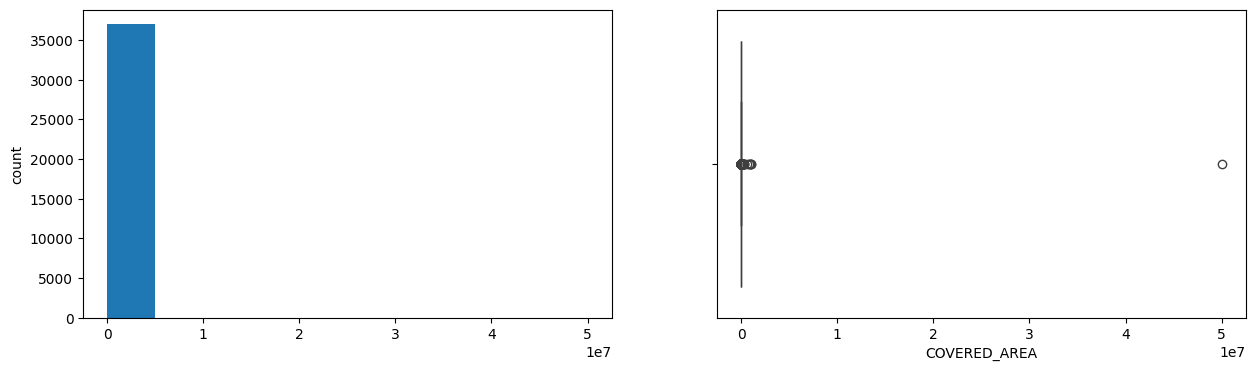

ROOMS
Skew : 3.22


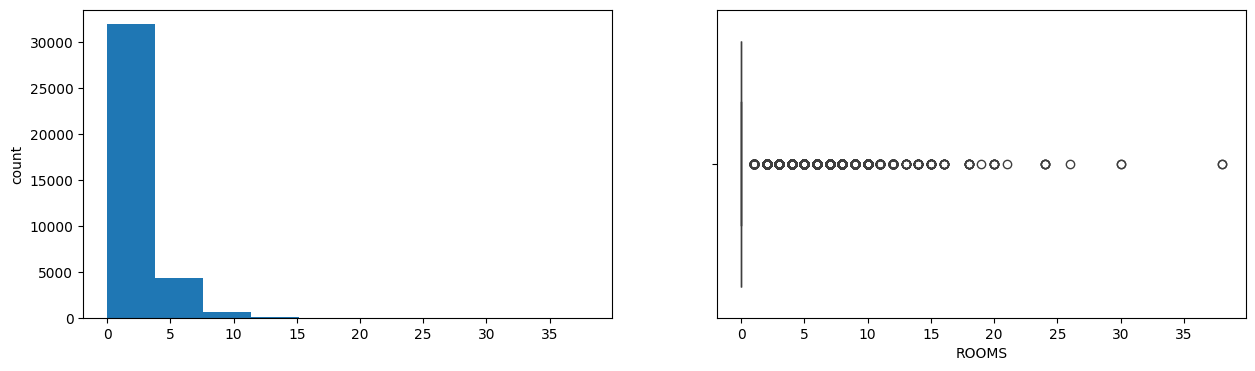

PRICE
Skew : 7.96


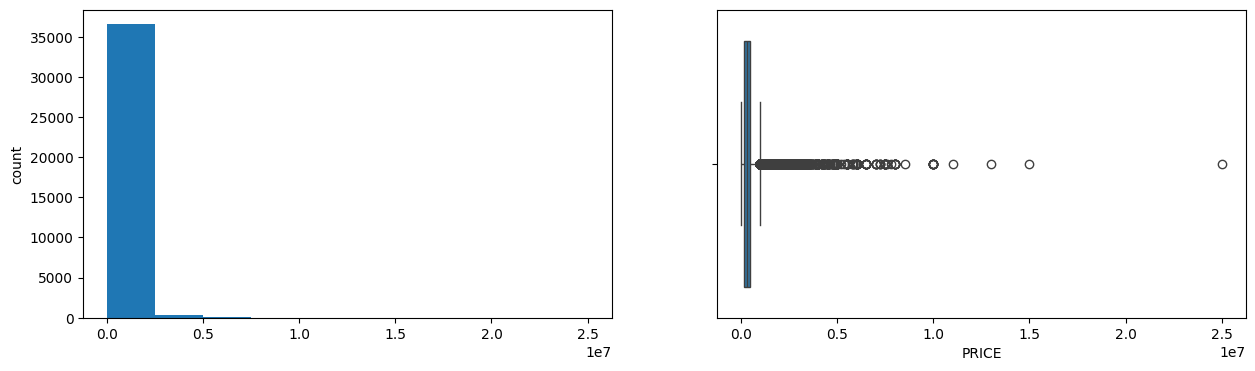

FULL_BATHROOMS
Skew : 1.73


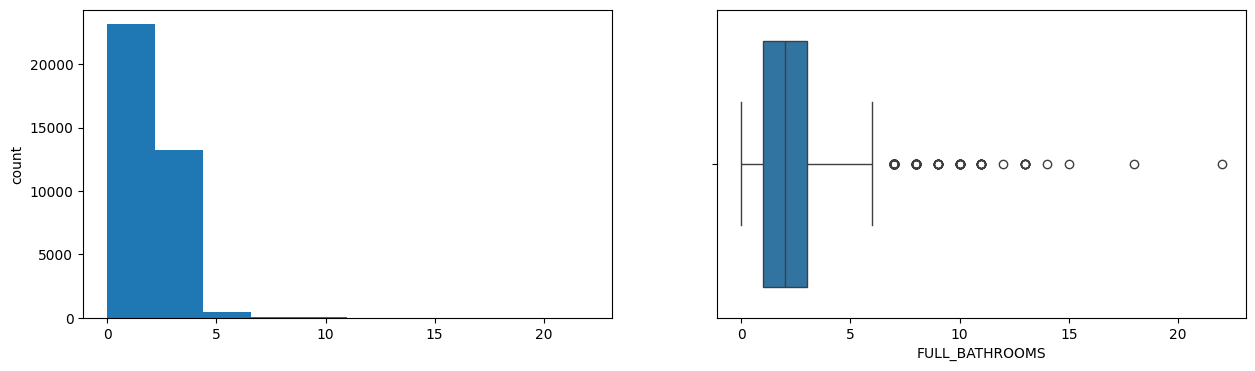

BEDROOMS
Skew : 2.77


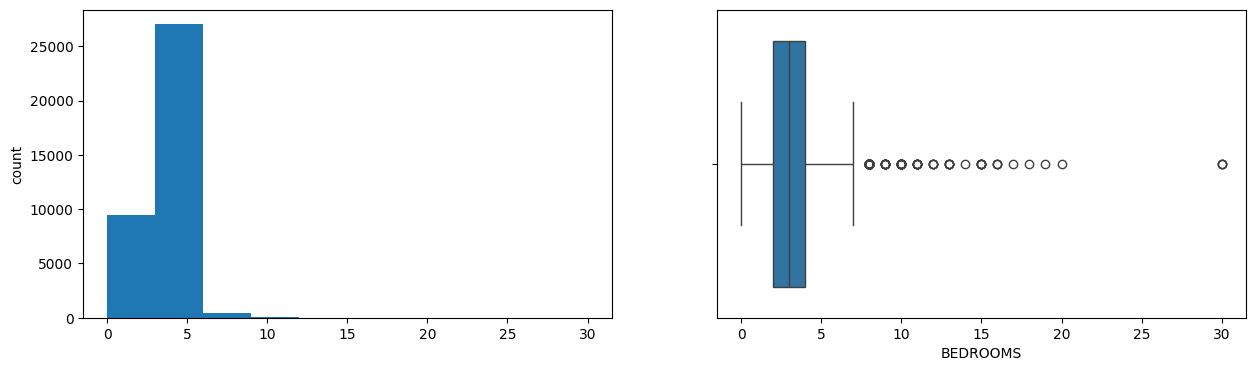

GARAGE
Skew : 41.92


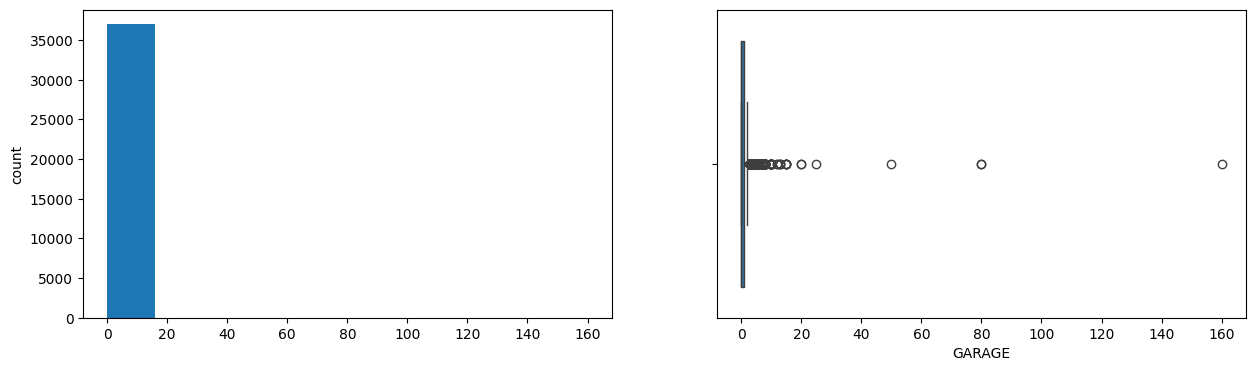

In [55]:
numerical_columns = new_df.select_dtypes(include=np.number).columns
for col in numerical_columns:
    print(col)
    print('Skew :',round(new_df[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    new_df[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=new_df[col])
    plt.show()

En las siguientes visualizaciones, decidimos quitar el 10% de los datos de la derecha para las variables: COVERED_AREA', 'PRICE' , 'ROOMS', 'GARAGE', ya que observamos que teniamos muchisimos outliers y se nos dificultaba la visualizaciión.

COVERED_AREA
Skew : 1.1


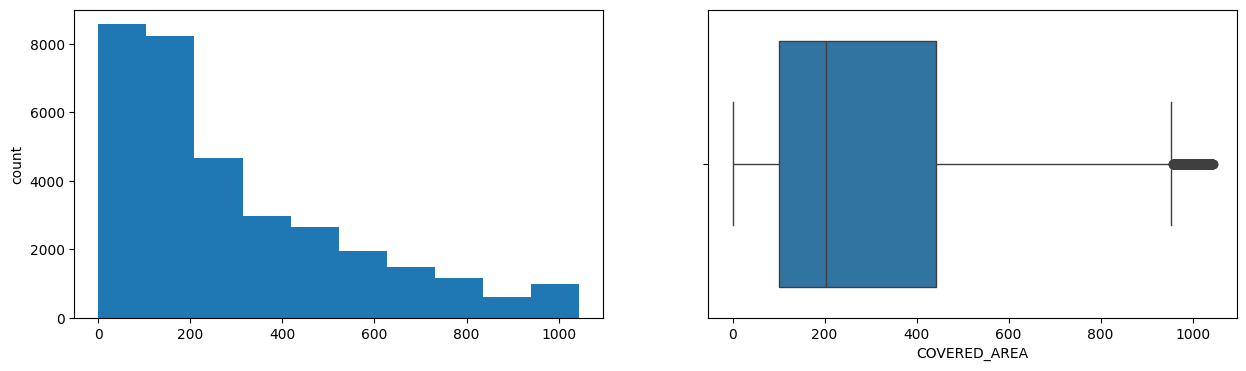

PRICE
Skew : 0.98


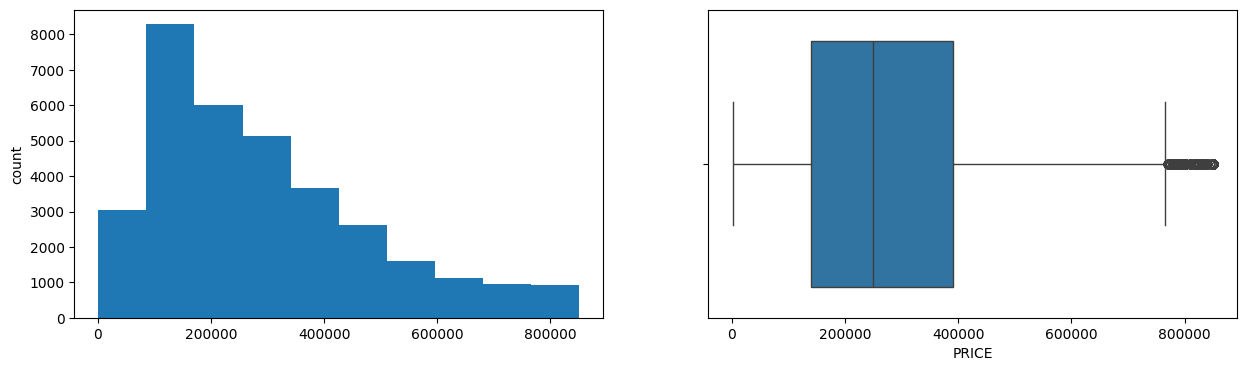

ROOMS
Skew : 3.04


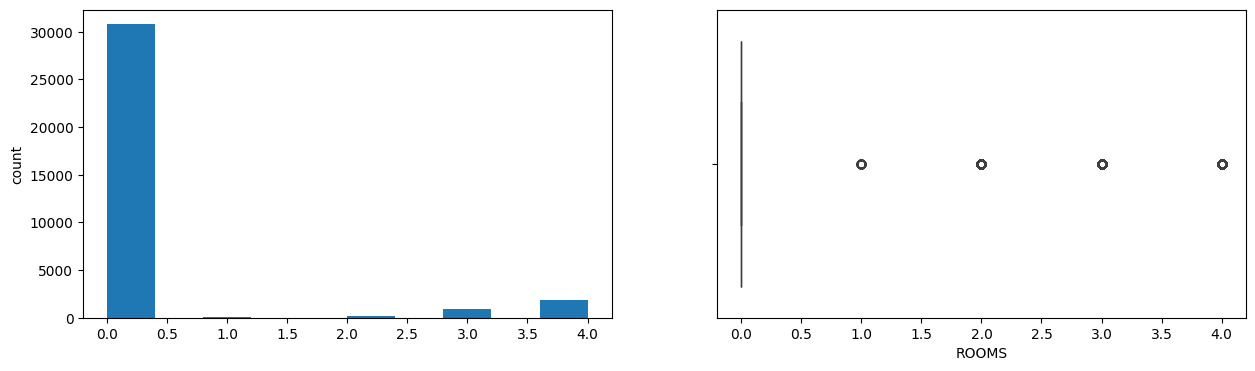

FULL_BATHROOMS
Skew : 1.73


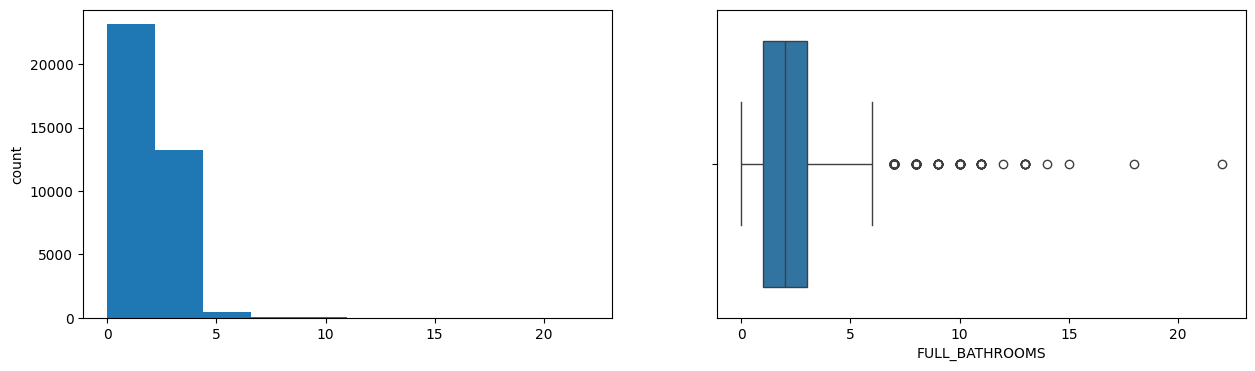

BEDROOMS
Skew : 2.77


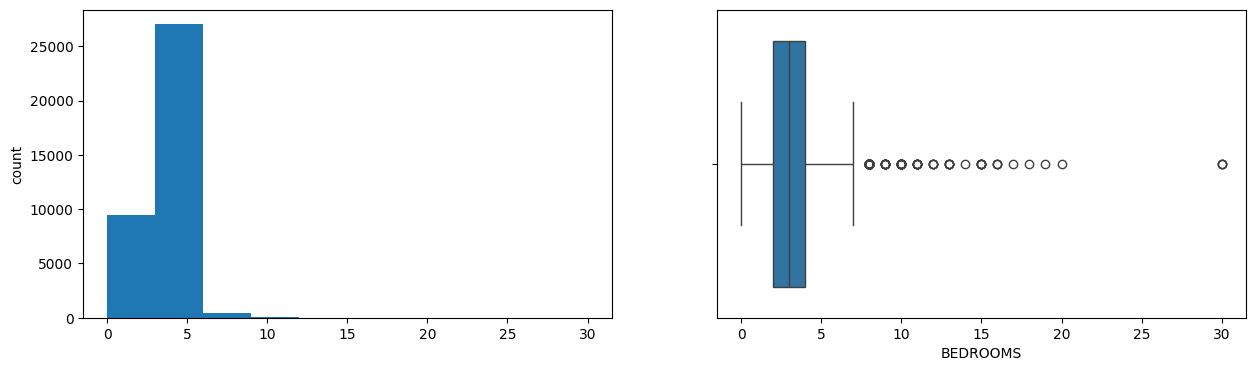

GARAGE
Skew : 0.88


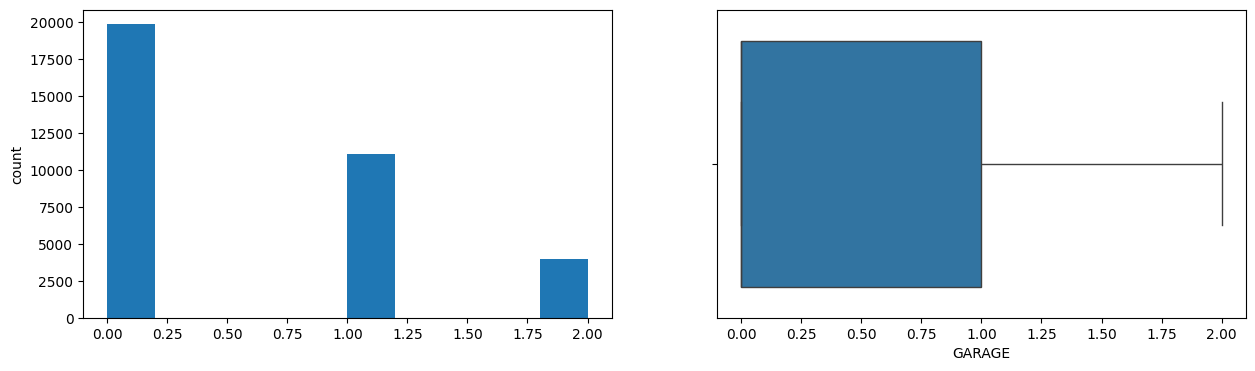

In [56]:
# Gráficos
data_cont=new_df[['COVERED_AREA','PRICE','ROOMS','FULL_BATHROOMS','BEDROOMS','GARAGE']]
pd.set_option('display.float_format', lambda x: '%.2f' % x)
needs_90_per_cent = ['COVERED_AREA', 'PRICE' , 'ROOMS', 'GARAGE']
for col in data_cont.columns:
    print(col)
    # Calculate the 90th percentile
    limit_90th_percentile = data_cont[col].quantile(0.90 if col in needs_90_per_cent else 1)

    # Filter out the top 10%
    data_filtered = data_cont[data_cont[col] <= limit_90th_percentile][col]

    print('Skew :',round(data_filtered.skew(),2))
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data_filtered.hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data_filtered)
    plt.show()

Procedemos a eliminar algunos outliers de las variables:

- COVERED_AREA: La mayoría de los datos está súper concentrada entre 0 y 200 metros cuadrados aprox. La mitad central de los datos se mueve entre 110 y 560 metros cuadrados. Tiene una asimetría positiva (la cola larga se va a la derecha). Esta es muy grande, a pesar de que la mediana es solo 246, el máximo llega a 5000000. Se ve una cantidad grande de outliers.

- PRICE: La mayoría de los datos están concentrada en el entorno de los  100000. La mitad central de los datos se mueve entre 150000 y 480000. Tiene una asimetría positiva (la cola larga se va a la derecha). Esta asimetría es muy grande, a pesar de que la mediana es 275000, el máximo real del dataset llega a 25000000. Se ve una cantidad grande de outliers.

- ROOMS: La mayoría de los datos están concentrados en cero habitaciones. Tiene una asimetría positiva muy grande: la mediana es 0, pero el máximo llega a 38.

- FULL_BATHROOMS: La mayoría de los datos estan concentrados entre 0 y 2 baños. con una caída en la frecuencia a partir de los 3 baños. La mitad central de los datos se mueve entre 1 y 3. Tiene una asimetría positiva. A pesar de que la mediana es solo 2, el máximo llega a 22. El boxplot muestra que hay muchos outliers que se extienden hasta el máximo.

- BEDROOMS: La mayoría de los datos estan concentrados entre 3 y 5 dormitorios. La mitad central de los datos se mueve entre 2 y 4. Tiene una asimetría positiva. A pesar de que la mediana es 3, el máximo llega a 30.

- GARAGE: La mayoría de las casas tienen cero o un garaje. El pico más alto está claramente en 0 garajes. La mediana es 0, pero el máximo llega a 160.

Dicho esto, hay algunos outliers que nos llaman mucho la atención:
- Casas con mas de 30 habitaciones, con 22 baños, e incluso con 160 garages. Para el caso de las habitaciones y baños, se puede observar gracias a la descripción del dataset original, que estamos ante ventas de edificios. En el caso del garage, algunos pueden deberse a errores en los datos(el caso del de 160) y en otros por oportunidades de inversion ("SINERGIA INVERSIONES VENDE DOS CASAS PARA EMPRENDIMIENTO ...")

In [57]:
df[(df['ROOMS'] >= 30) | (df['BEDROOMS'] >= 30) | (df['FULL_BATHROOMS'] > 20) | (df['GARAGE'] > 20)]

,NEIGHBORHOOD,COVERED_AREA,LISTING_TYPE_ID,ADDRESS_CITY_NAME,ROOMS,WITH_VIRTUAL_TOUR,HAS_AIR_CONDITIONING,PROCESS_DATE,TOTAL_AREA,DESCRIPTION,ITEM_CONDITION,PROCESS_DATE.1,ADDRESS_STATE,ADDRESS,CONDITION,TITLE,PRICE,ADDRESS_LINE,CATEGORY_ID,ORIGEN,SITE_ID,HAS_TELEPHONE_LINE,ID,DESCRIPTION.1,FULL_BATHROOMS,OPERATION,BEDROOMS,CURRENCY_ID,PROPERTY_TYPE,POSITION,ARTICLE_ID,GARAGE,CONSTRUCTION_YEAR
658,NaN,1535.00,gold_premium,Ciudad Vieja,30,NaN,No,NaN,1535.00,NaN,Usado,08/03/2023,Montevideo,NaN,used,"Edificio Palacio Amézaga, Oportunidad De Inver...",1000000,BUENOS AIRES 495,MLU1468,meli,MLU,No,MLU474107663,NaN,6,Venta,10.00,USD,Casa,NaN,NaN,0,NaN
1411,NaN,738.00,gold_premium,Punta Carretas,1111,NaN,NaN,NaN,738.00,NaN,Nuevo,08/03/2023,Montevideo,NaN,new,"Oportunidad De Inversión, Edificio Con 12 Apar...",2000000,"Doctor José María Montero 2700 - 3000, Montevi...",MLU1468,meli,MLU,Sí,MLU624736480,NaN,12,Venta,22.00,USD,Casa,NaN,NaN,0,NaN
1769,NaN,457.00,gold_premium,Ciudad Vieja,38,NaN,No,NaN,457.00,NaN,Usado,08/03/2023,Montevideo,NaN,used,"Hospedaje Hotel Pensión Con Renta, 30 Habitaci...",480000,guarani 1470,MLU1468,meli,MLU,Sí,MLU613059371,NaN,5,Venta,30.00,USD,Casa,NaN,NaN,0,NaN
4235,NaN,457.00,gold_premium,Ciudad Vieja,30,No,No,NaN,457.00,DescripciónBarrio Ciudad ViejaGuaraní esq. 25 ...,Usado,26/02/2025,Montevideo,NaN,used,Oportunidad De Inversión. Casa Hospedaje En V...,479000,Guaraní Esq. 25 de Mayo,MLU1468,meli,MLU,No,MLU692643450,NaN,5,Venta,30.00,USD,Casa,NaN,NaN,0,NaN
7038,NaN,457.00,silver,Ciudad Vieja,38,No,No,NaN,457.00,DescripciónVISION Vende Hospedaje de 30 habita...,Usado,03/03/2025,Montevideo,NaN,used,Oportunidad De Inversion: Venta De Hospedaje H...,479000,guarani 1470,MLU1468,meli,MLU,Sí,MLU676629270,NaN,5,Venta,30.00,USD,Casa,NaN,NaN,0,NaN
7051,NaN,1535.00,gold_premium,Ciudad Vieja,30,No,No,NaN,1535.00,Sin descripcion,Usado,03/03/2025,Montevideo,NaN,used,"Edificio Palacio Amézaga, Oportunidad De Inver...",1000000,BUENOS AIRES 495,MLU1468,meli,MLU,No,MLU714533788,NaN,6,Venta,10.00,USD,Casa,NaN,NaN,0,NaN
8918,NaN,215.00,gold_premium,Carrasco,11,No,No,NaN,496.00,DescripciónGran Oportunidad de Inversión!! ven...,Usado,31/03/2025,Montevideo,NaN,used,"Imperdible!! Oportunidad, Venta De 3 Casas Sól...",90000,"Cno. Oncativo 2775, Montevideo",MLU1468,meli,MLU,Sí,MLU649937183,NaN,22,Venta,4.00,USD,Casa,NaN,NaN,0,NaN
17188,Ciudad Vieja,400.00,NaN,NaN,0,NaN,NaN,2023-04-28,NaN,NaN,NaN,NaN,NaN,Bueno Aires y Misiones,NaN,Venta ciudad vieja,350.000,NaN,NaN,gallito,NaN,NaN,NaN,Excelente Padrón en ciudad vieja. Calle Buenos...,3,Venta,4.00,USD,Casa,NaN,18419839.00,50,1930.00
24874,Brazo Oriental,1434.00,NaN,NaN,0,NaN,NaN,2023-04-28,NaN,NaN,Para reciclar,NaN,NaN,Av. SAN MARTIN 3606 y R. KOCK,NaN,2023. SAN MARTÍN 3606: CASA TERRENO 1.434 m2,250.000,NaN,NaN,gallito,NaN,NaN,NaN,NaN,2,Venta,4.00,USD,Casa,NaN,16031422.00,80,1940.00
26548,Ciudad Vieja,400.00,NaN,NaN,0,NaN,NaN,2023-05-01,NaN,NaN,NaN,NaN,NaN,Bueno Aires y Misiones,NaN,Venta ciudad vieja,350.000,NaN,NaN,gallito,NaN,NaN,NaN,Excelente Padrón en ciudad vieja. Calle Buenos...,3,Venta,4.00,USD,Casa,NaN,18419839.00,50,1930.00


In [58]:
# eliminamos la variable rooms.
new_df = new_df.drop(columns=['ROOMS'])
df_sin_outliers_para_catboost = df_sin_outliers_para_catboost.drop(columns=['ROOMS'])

In [59]:
# quitamos el 10% de los outliers de price
Q1 = new_df['PRICE'].quantile(0.25)
Q3 = new_df['PRICE'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
df_sin_outliers = new_df[new_df['PRICE'] <= upper_bound]

# quitamos los outliers de coverd_area > 200 igual que 0.
df_sin_outliers = df_sin_outliers[(df_sin_outliers['COVERED_AREA'] <= 200) & (df_sin_outliers['COVERED_AREA'] > 0)]
df_sin_outliers_para_catboost= df_sin_outliers_para_catboost[(df_sin_outliers_para_catboost['COVERED_AREA']<= 200) & (df_sin_outliers_para_catboost['COVERED_AREA'] > 0)]

# quitamos el precio con valor 1234
df_sin_outliers = df_sin_outliers[df_sin_outliers['PRICE'] != 1234]
df_sin_outliers_para_catboost=df_sin_outliers_para_catboost[df_sin_outliers_para_catboost['PRICE'] != 1234]

# quitamos el covered_area en 1
df_sin_outliers = df_sin_outliers[df_sin_outliers['COVERED_AREA'] != 1]
df_sin_outliers_para_catboost=df_sin_outliers_para_catboost[df_sin_outliers_para_catboost['COVERED_AREA'] !=1]




In [60]:
# Impute COVERED_AREA less than 10 with the mean grouped by bathrooms and bedrooms
df_sin_outliers['COVERED_AREA'] = df_sin_outliers.apply(
    lambda row: df_sin_outliers[(df_sin_outliers['FULL_BATHROOMS'] == row['FULL_BATHROOMS']) & (df_sin_outliers['BEDROOMS'] == row['BEDROOMS'])]['COVERED_AREA'].mean() if row['COVERED_AREA'] < 10 else row['COVERED_AREA'],
    axis=1
)

df_sin_outliers_para_catboost['COVERED_AREA']=df_sin_outliers_para_catboost.apply(
    lambda row: df_sin_outliers_para_catboost[(df_sin_outliers_para_catboost['FULL_BATHROOMS'] == row['FULL_BATHROOMS']) & (df_sin_outliers_para_catboost['BEDROOMS'] == row['BEDROOMS'])]['COVERED_AREA'].mean() if row['COVERED_AREA'] < 10 else row['COVERED_AREA'],
  axis=1
)

# quitamos las restantes de 1
df_sin_outliers = df_sin_outliers[df_sin_outliers['COVERED_AREA'] != 1]
df_sin_outliers_para_catboost=df_sin_outliers_para_catboost[df_sin_outliers_para_catboost['COVERED_AREA'] !=1]

COVERED_AREA
Skew : 0.18


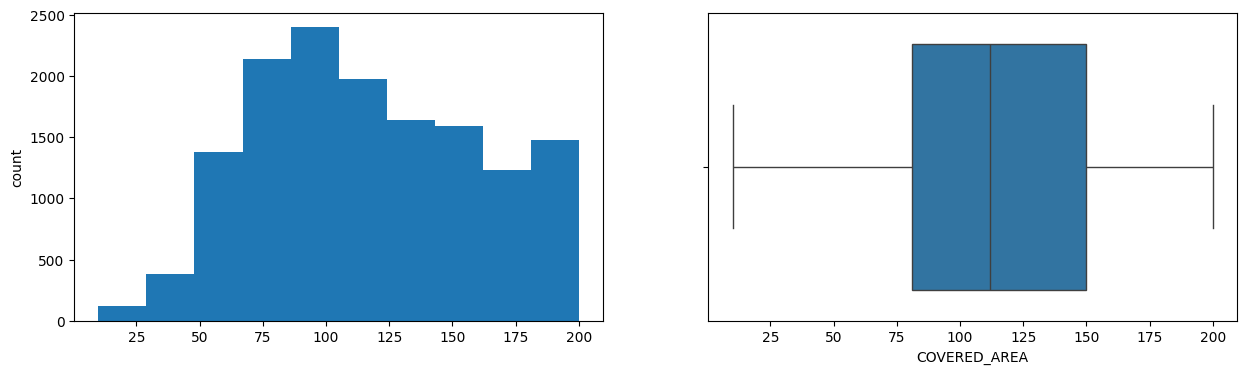

PRICE
Skew : 1.63


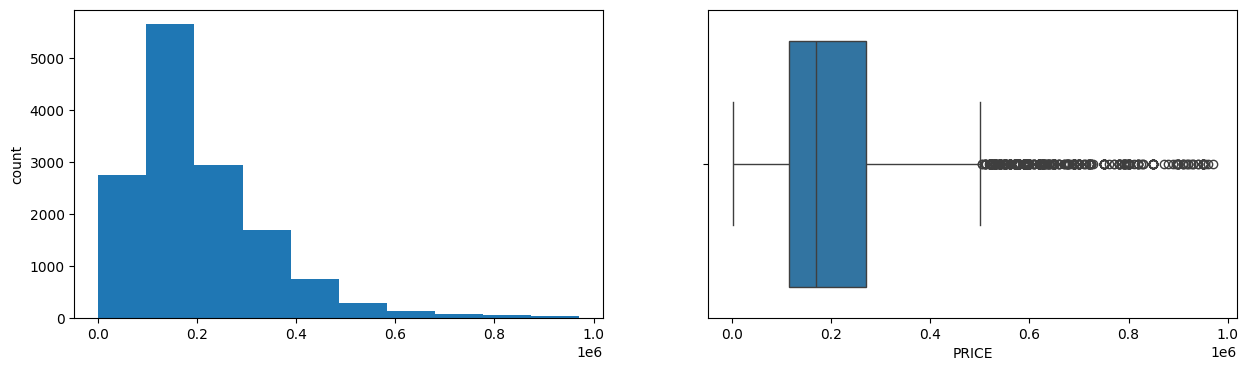

FULL_BATHROOMS
Skew : 0.9


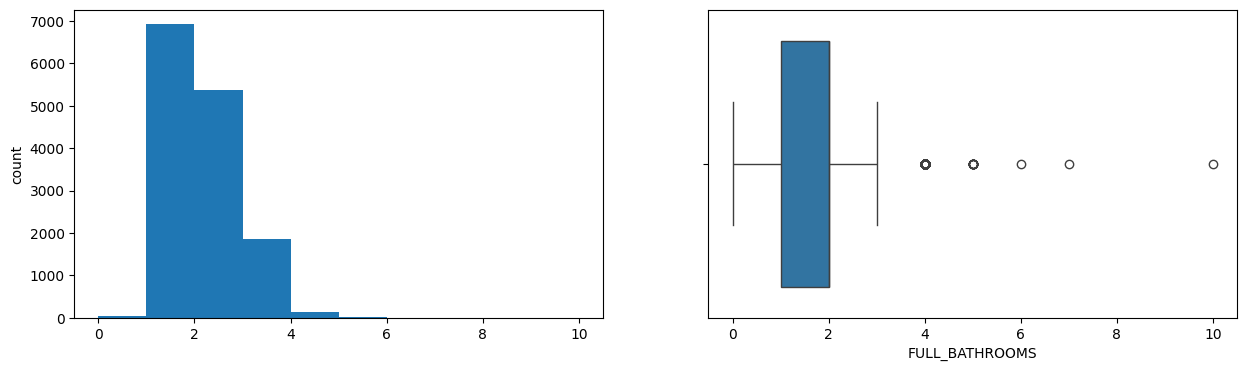

BEDROOMS
Skew : 0.56


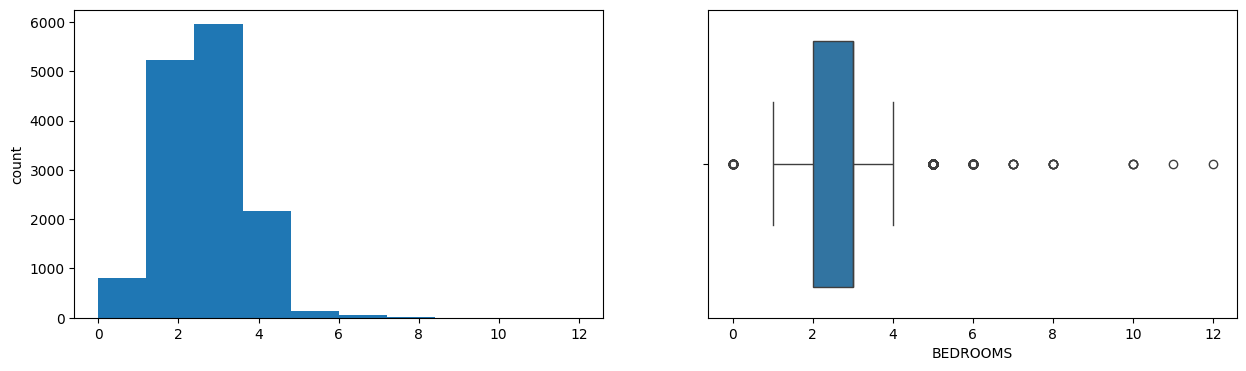

GARAGE
Skew : 3.16


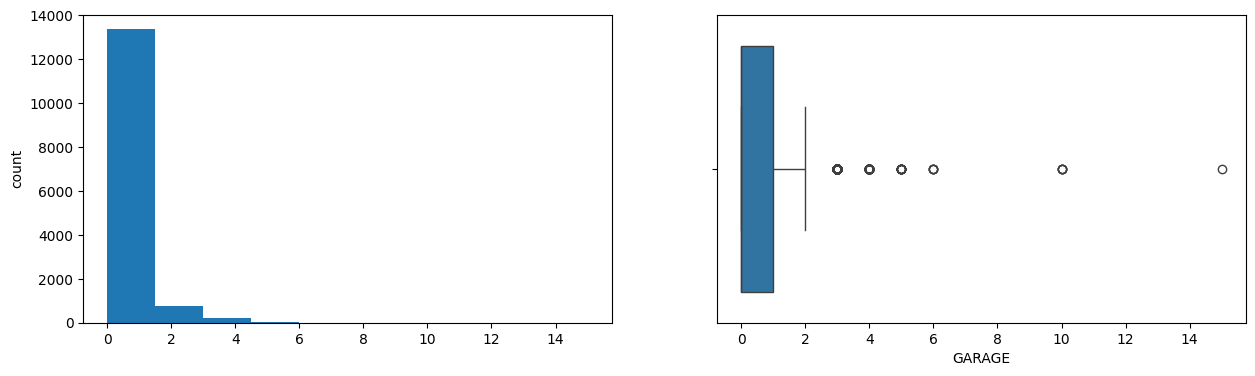

In [61]:
numerical_columns = df_sin_outliers.select_dtypes(include=np.number).columns
for col in numerical_columns:
    print(col)
    print('Skew :',round(df_sin_outliers[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    df_sin_outliers[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df_sin_outliers[col])
    plt.show()

In [62]:
#new_df = new_df[new_df['COVERED_AREA'] < 1300.00]
df_sin_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14337 entries, 0 to 177373
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NEIGHBORHOOD          14337 non-null  object 
 1   COVERED_AREA          14337 non-null  float64
 2   LISTING_TYPE_ID       14337 non-null  object 
 3   WITH_VIRTUAL_TOUR     14337 non-null  object 
 4   HAS_AIR_CONDITIONING  14337 non-null  object 
 5   ADDRESS_STATE         14337 non-null  object 
 6   CONDITION             14337 non-null  object 
 7   PRICE                 14337 non-null  float64
 8   ORIGEN                14337 non-null  object 
 9   FULL_BATHROOMS        14337 non-null  int64  
 10  BEDROOMS              14337 non-null  float64
 11  GARAGE                14337 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 1.4+ MB


In [63]:
df_sin_outliers.describe()

,COVERED_AREA,PRICE,FULL_BATHROOMS,BEDROOMS,GARAGE
count,14337.00,14337.00,14337.00,14337.00,14337.00
mean,116.90,207224.29,1.67,2.71,0.40
std,44.50,132914.24,0.75,0.88,0.72
min,10.00,1350.00,0.00,0.00,0.00
25%,81.00,115000.00,1.00,2.00,0.00
50%,112.00,170000.00,2.00,3.00,0.00
75%,150.00,270000.00,2.00,3.00,1.00
max,200.00,970000.00,10.00,12.00,15.00


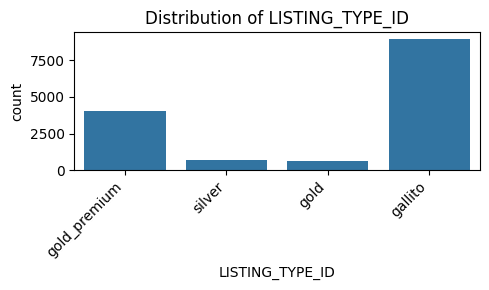

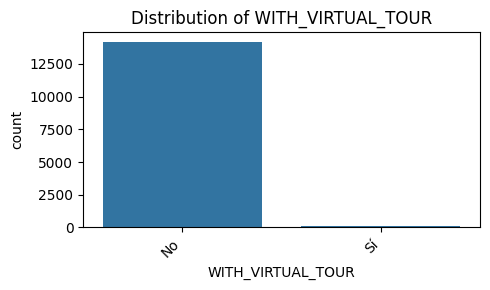

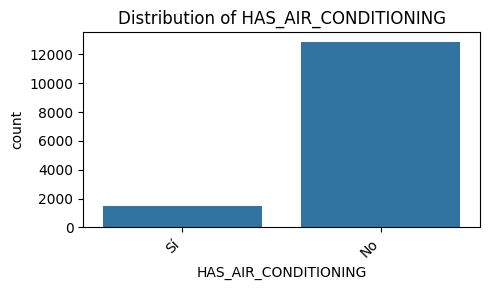

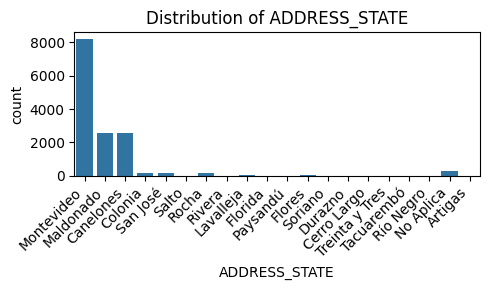

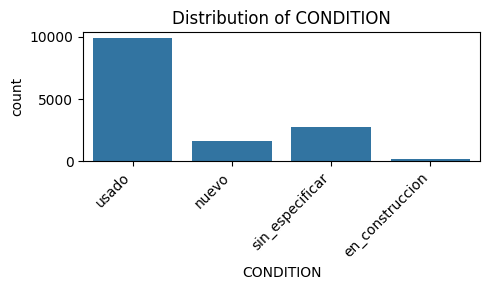

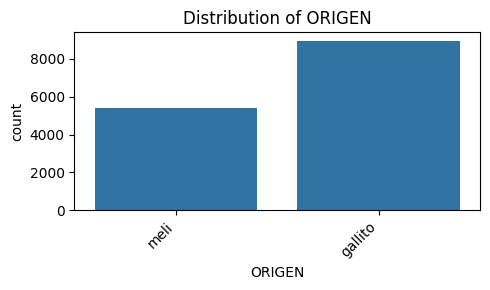

In [64]:
categorical_variables = df_sin_outliers.select_dtypes(include=['object'])
categorical_variables_sin_neighborhood = categorical_variables.drop(columns=['NEIGHBORHOOD'])
for col in categorical_variables_sin_neighborhood.columns:
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df_sin_outliers, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [65]:
# contar la cantidad de No Aplica que hay en ADDRESS_STATE
df_sin_outliers['ADDRESS_STATE'].value_counts()

,count
ADDRESS_STATE,
Montevideo,8189
Canelones,2574
Maldonado,2559
No Aplica,302
Rocha,191
Colonia,160
San José,160
Flores,57
Lavalleja,36


In [66]:
#
df_sin_outliers_para_catboost = df_sin_outliers.copy()

departments_to_group = [
    'No Aplica', 'Rocha', 'San José', 'Colonia', 'Flores', 'Lavalleja',
    'Treinta y Tres', 'Florida', 'Paysandú', 'Durazno', 'Rivera', 'Salto',
    'Soriano', 'Tacuarembó', 'Cerro Largo', 'Río Negro', 'Artigas'
]

df_sin_outliers['ADDRESS_STATE'] = df_sin_outliers['ADDRESS_STATE'].replace(departments_to_group, 'Otros')

print(df_sin_outliers['ADDRESS_STATE'].value_counts())

ADDRESS_STATE
Montevideo    8189
Canelones     2574
Maldonado     2559
Otros         1015
Name: count, dtype: int64


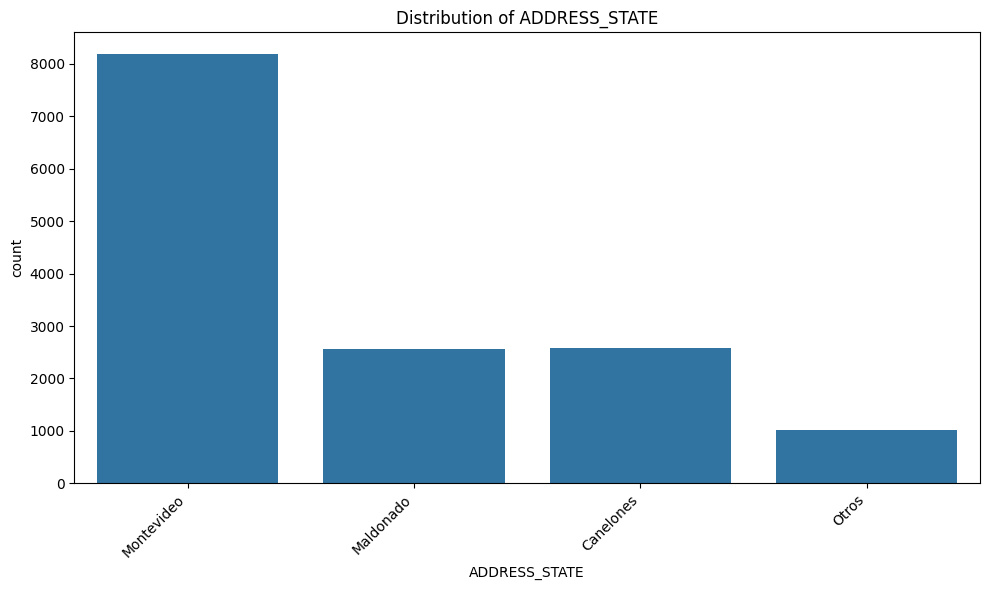

In [67]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sin_outliers, x='ADDRESS_STATE')
plt.title('Distribution of ADDRESS_STATE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **5.2 Análisis Bivariado:**

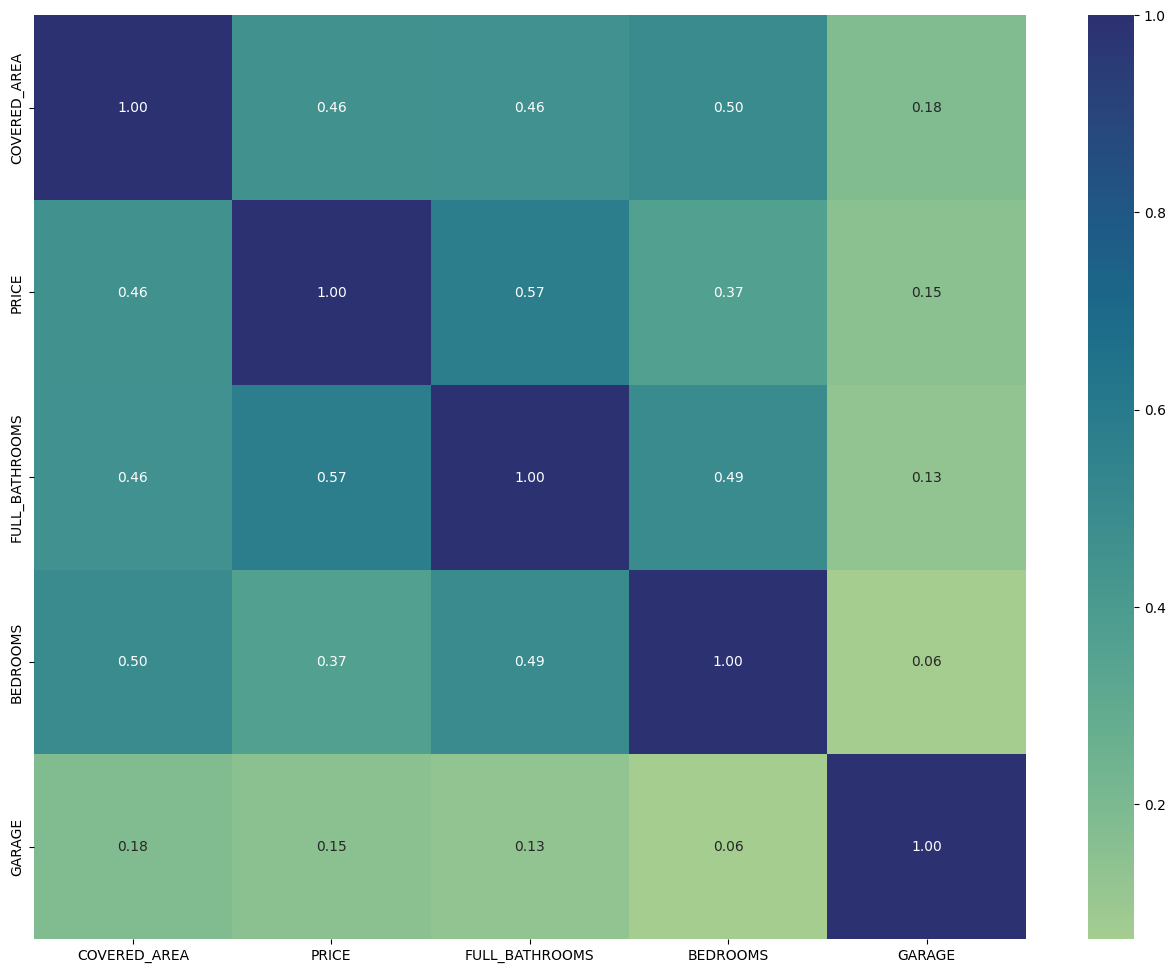

In [68]:
numerical_columns = df_sin_outliers.select_dtypes(include=np.number).columns

plt.figure(figsize=(16,12))
sns.heatmap(df_sin_outliers[numerical_columns].corr(), annot=True, fmt='0.2f', cmap="crest")
plt.show()

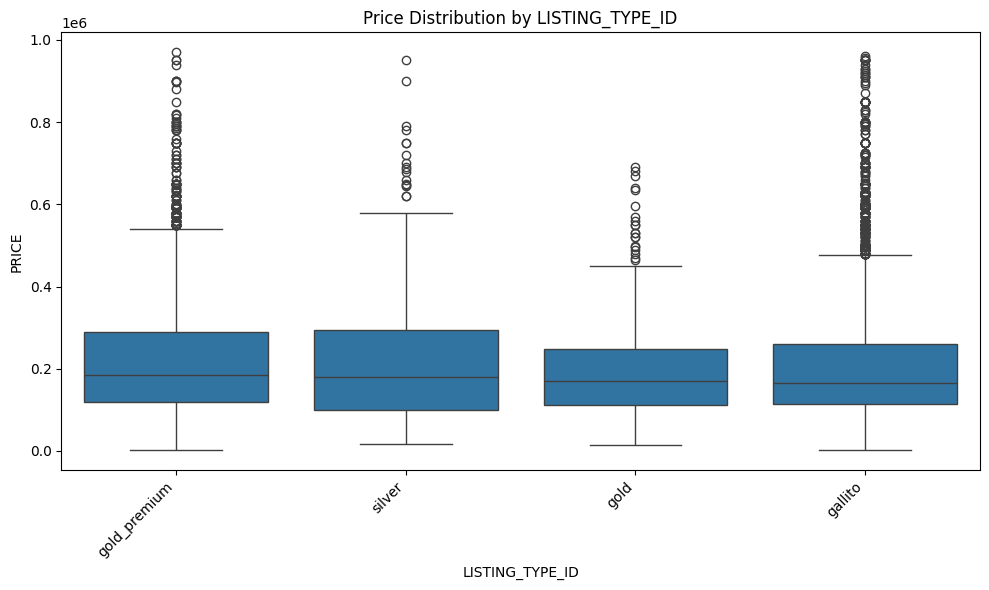

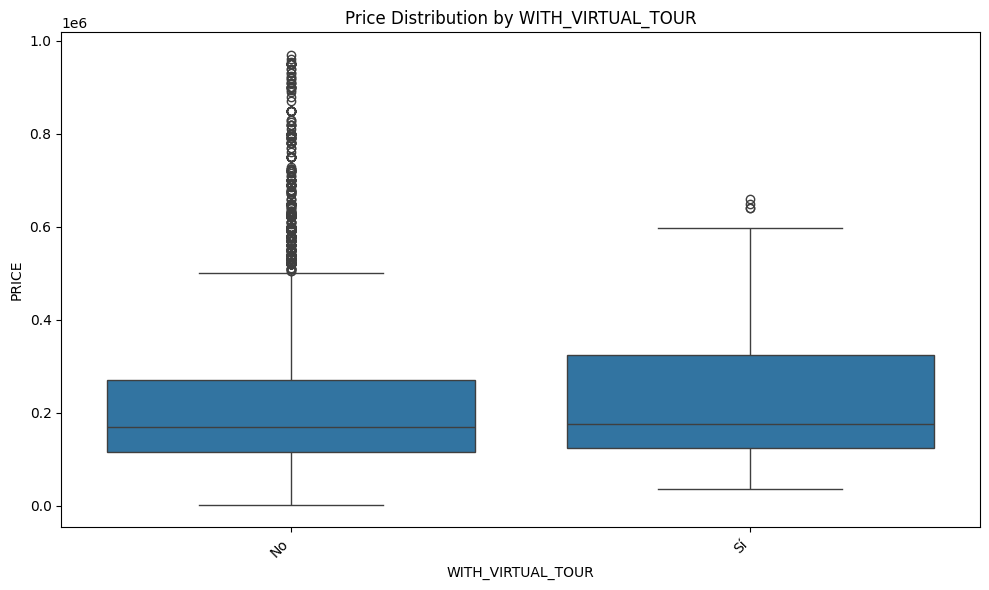

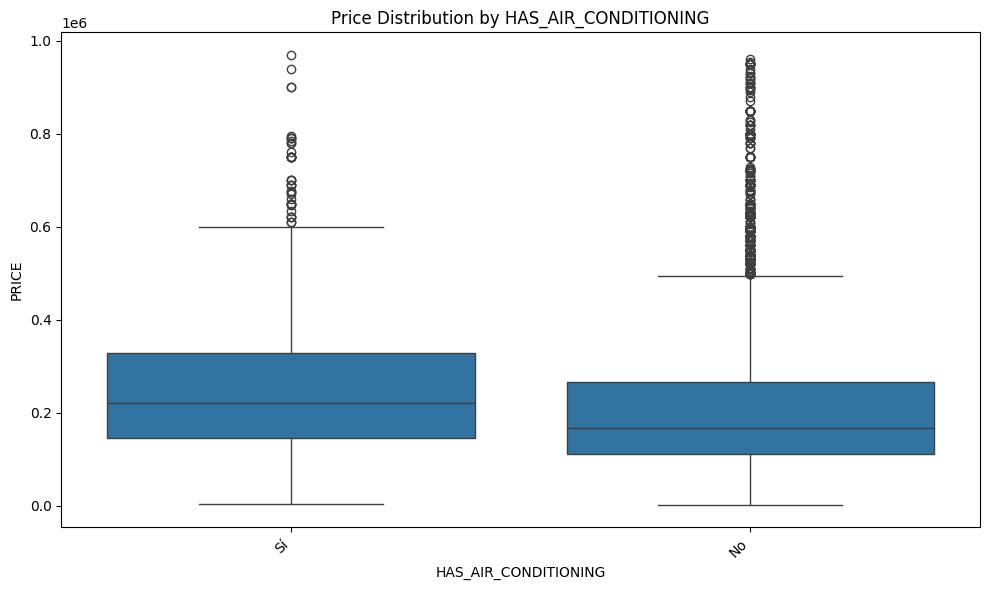

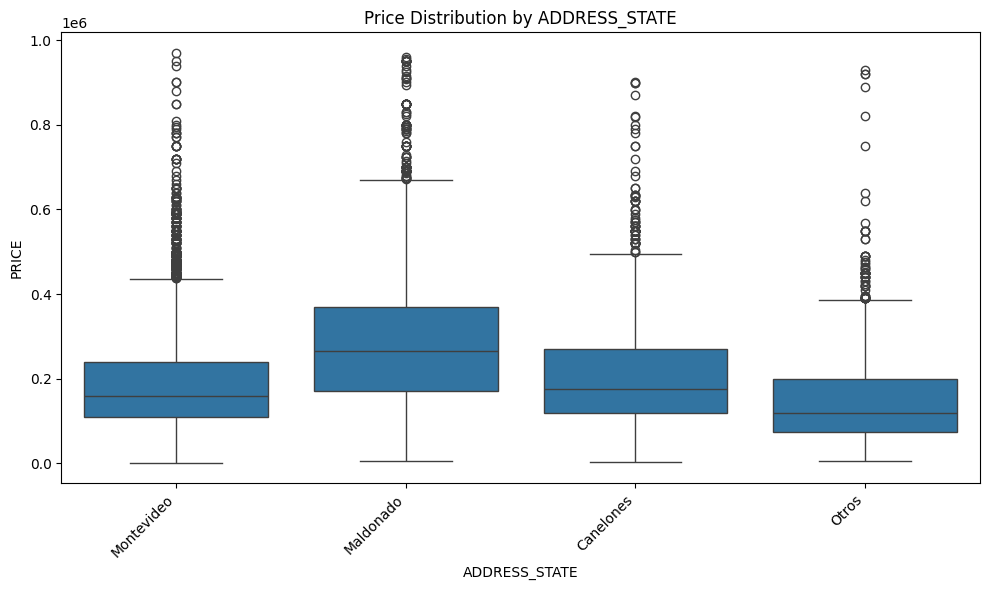

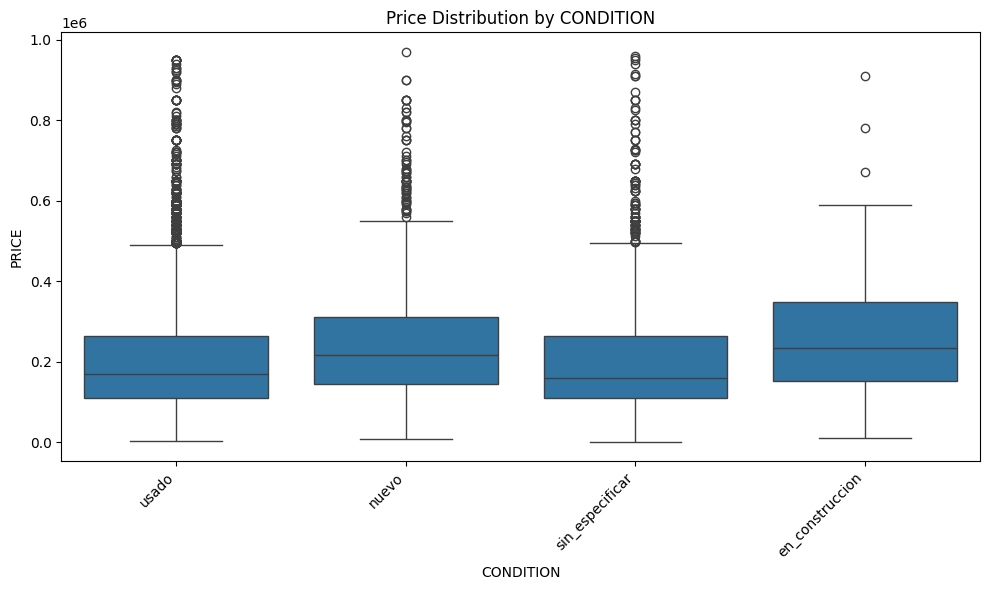

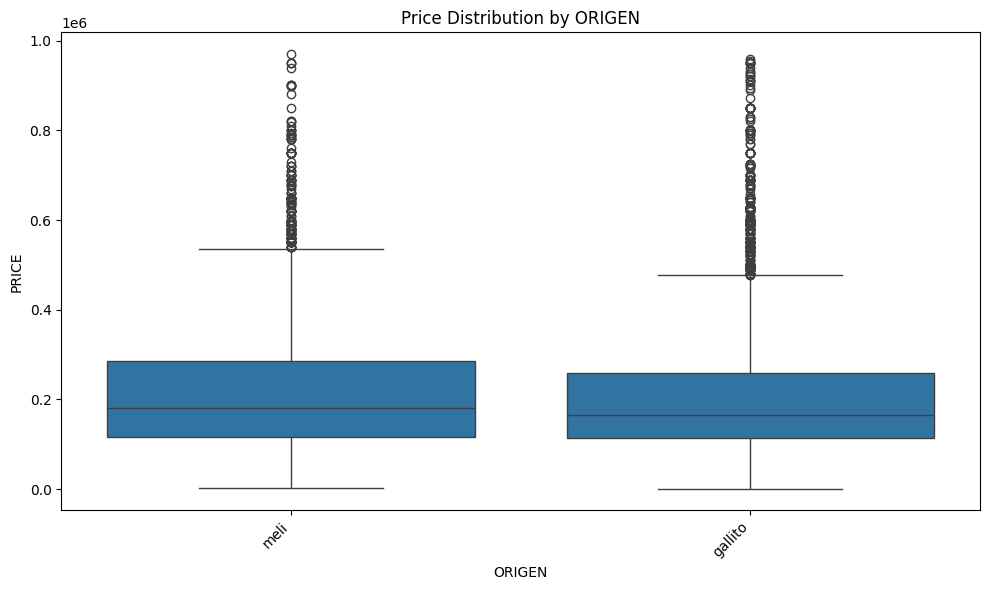

In [69]:
categorical_variables = df_sin_outliers.select_dtypes(include=['object']).columns
categorical_variables_to_plot = [col for col in categorical_variables if col != 'NEIGHBORHOOD']

for col in categorical_variables_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_sin_outliers, x=col, y='PRICE')
    plt.title(f'Price Distribution by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

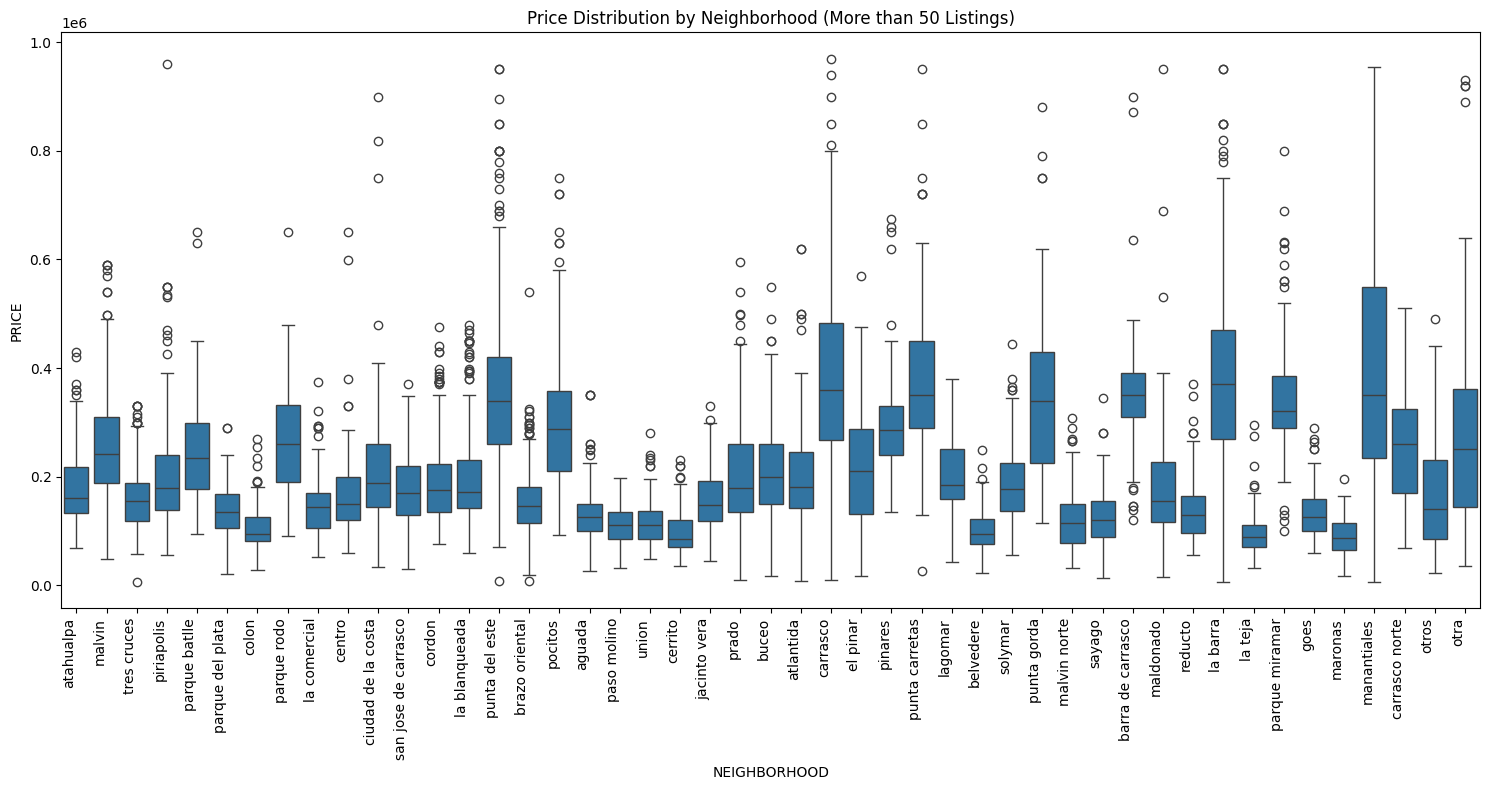

In [70]:
# Get the count of listings per neighborhood
neighborhood_counts = df_sin_outliers['NEIGHBORHOOD'].value_counts()

# Identify neighborhoods with more than 50 listings
neighborhoods_to_plot = neighborhood_counts[neighborhood_counts > 100].index

# Filter the DataFrame to include only these neighborhoods
df_filtered_neighborhoods = df_sin_outliers[df_sin_outliers['NEIGHBORHOOD'].isin(neighborhoods_to_plot)]

# Create the boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_filtered_neighborhoods, x='NEIGHBORHOOD', y='PRICE')
plt.title('Price Distribution by Neighborhood (More than 50 Listings)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [71]:
df_sin_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14337 entries, 0 to 177373
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NEIGHBORHOOD          14337 non-null  object 
 1   COVERED_AREA          14337 non-null  float64
 2   LISTING_TYPE_ID       14337 non-null  object 
 3   WITH_VIRTUAL_TOUR     14337 non-null  object 
 4   HAS_AIR_CONDITIONING  14337 non-null  object 
 5   ADDRESS_STATE         14337 non-null  object 
 6   CONDITION             14337 non-null  object 
 7   PRICE                 14337 non-null  float64
 8   ORIGEN                14337 non-null  object 
 9   FULL_BATHROOMS        14337 non-null  int64  
 10  BEDROOMS              14337 non-null  float64
 11  GARAGE                14337 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 1.4+ MB


In [72]:
Q1 = new_df['PRICE'].quantile(0.25)
Q3 = new_df['PRICE'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
new_df[new_df['PRICE'] <= upper_bound]
df_sin_outliers_para_catboost[df_sin_outliers_para_catboost['PRICE'] <= upper_bound]

,NEIGHBORHOOD,COVERED_AREA,LISTING_TYPE_ID,WITH_VIRTUAL_TOUR,HAS_AIR_CONDITIONING,ADDRESS_STATE,CONDITION,PRICE,ORIGEN,FULL_BATHROOMS,BEDROOMS,GARAGE
0,atahualpa,151.00,gold_premium,No,Sí,Montevideo,usado,218000.00,meli,2,4.00,0
1,malvin,162.00,gold_premium,No,No,Montevideo,usado,400000.00,meli,2,3.00,0
2,tres cruces,80.00,gold_premium,No,Sí,Montevideo,nuevo,160000.00,meli,2,2.00,0
3,malvin,100.00,gold_premium,No,Sí,Montevideo,usado,250000.00,meli,1,3.00,0
4,piriapolis,28.00,gold_premium,No,No,Maldonado,usado,85000.00,meli,1,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
177280,villa munoz,106.00,gallito,No,No,Montevideo,usado,129000.00,gallito,2,2.00,0
177355,la blanqueada,80.00,gallito,No,No,Montevideo,usado,167000.00,gallito,1,2.00,1
177362,parque batlle,125.00,gallito,No,No,Montevideo,nuevo,290000.00,gallito,2,3.00,1
177366,buceo,90.00,gallito,No,No,Montevideo,usado,220000.00,gallito,2,3.00,1


# **6. Modelo de Regresión Lineal:**

## **6.1 Preparación de la Base**

In [73]:
# 1. Definir variables
y_var = 'PRICE'
x_vars = ['NEIGHBORHOOD', 'COVERED_AREA', 'LISTING_TYPE_ID', 'WITH_VIRTUAL_TOUR',
          'HAS_AIR_CONDITIONING', 'ADDRESS_STATE', 'CONDITION',
          'FULL_BATHROOMS', 'BEDROOMS', 'GARAGE']

df = df_sin_outliers.copy()

# Eliminar origen porque contiene información muy similar a listing type
if 'ORIGEN' in df.columns:
    df = df.drop(columns=['ORIGEN'])
    df_sin_outliers_para_catboost = df_sin_outliers_para_catboost.drop(columns=['ORIGEN'])


In [74]:
# 2. Agrupar barrios poco frecuentes

min_obs = 100
neigh_counts = df['NEIGHBORHOOD'].value_counts()
rare_neigh = neigh_counts[neigh_counts < min_obs].index
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].replace(rare_neigh, 'Otros')

In [75]:
# 3. Codificación de variables categóricas

# Seleccionar variables categóricas
categorical_cols = ['NEIGHBORHOOD', 'LISTING_TYPE_ID', 'ADDRESS_STATE', 'CONDITION',
                    'WITH_VIRTUAL_TOUR', 'HAS_AIR_CONDITIONING']

# Convertir a tipo 'category'
df[categorical_cols] = df[categorical_cols].astype('category')

# Crear variables dummies (drop_first=True para evitar multicolinealidad)
df_dummies = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=np.uint8)

In [76]:
# 4. Definir X e y
X = df_dummies.drop(columns=[y_var])
y = df_dummies[y_var]

# Agregar constante (intercepto)
X = sm.add_constant(X)

## **6.2 Modelos**

In [77]:
# # 5. Train/Test split y modelos
# # Usar X sin la constante para sklearn
# X_no_const = X.drop(columns=['const']) if 'const' in X.columns else X

# # Split
# X_tr, X_te, y_tr, y_te = train_test_split(X_no_const, y, test_size=0.2, random_state=42)

# # ---- OLS con statsmodels (entrenar en train, evaluar en test) ----
# ols_model = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
# print(ols_model.summary())

# y_pred_ols = ols_model.predict(sm.add_constant(X_te))
# r2_ols = r2_score(y_te, y_pred_ols)
# rmse_ols = np.sqrt(mean_squared_error(y_te, y_pred_ols))
# print(f"\nOLS (test)  R² = {r2_ols:.4f}   RMSE = {rmse_ols:,.2f}")

# # ---- Ridge y Lasso con CV ----
# alphas = np.logspace(-2, 3, 100)

# ridge = RidgeCV(alphas=alphas, cv=5).fit(X_tr, y_tr)
# y_pred_ridge = ridge.predict(X_te)
# print(f"Ridge (test) R² = {r2_score(y_te, y_pred_ridge):.4f}   RMSE = {np.sqrt(mean_squared_error(y_te, y_pred_ridge)):,.2f}")
# print("Alpha óptimo Ridge:", ridge.alpha_)

# lasso = LassoCV(alphas=None, cv=5, random_state=42, max_iter=10000).fit(X_tr, y_tr)
# y_pred_lasso = lasso.predict(X_te)
# print(f"Lasso (test) R² = {r2_score(y_te, y_pred_lasso):.4f}   RMSE = {np.sqrt(mean_squared_error(y_te, y_pred_lasso)):,.2f}")
# print("Alpha óptimo Lasso:", lasso.alpha_)

# Usar X sin la constante para sklearn, asegurando que la columna 'const' se elimina si existe.
X_no_const = X.drop(columns=['const']) if 'const' in X.columns else X

# Split: 80% para entrenamiento, 20% para prueba.
X_tr, X_te, y_tr, y_te = train_test_split(X_no_const, y, test_size=0.2, random_state=42)


print("="*60)
print("             MÉTRICAS DE RENDIMIENTO DE REGRESIÓN            ")
print("="*60)


## ----------------------------------------------------------------
## 1. OLS con statsmodels
## ----------------------------------------------------------------

print("\n--- REGRESIÓN OLS (Ordinary Least Squares) ---")
# Entrenamiento (statsmodels requiere añadir explícitamente la constante)
ols_model = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
print(ols_model.summary())

# Predicción en el conjunto de prueba
y_pred_ols = ols_model.predict(sm.add_constant(X_te))

# Evaluación de métricas
r2_ols = r2_score(y_te, y_pred_ols)
rmse_ols = np.sqrt(mean_squared_error(y_te, y_pred_ols))
mae_ols = mean_absolute_error(y_te, y_pred_ols)
mape_ols = mean_absolute_percentage_error(y_te, y_pred_ols)

print(f"\n[EVALUACIÓN OLS (TEST)]")
print(f"  R²   = {r2_ols:.4f}")
print(f"  RMSE = {rmse_ols:,.2f}")
print(f"  MAE  = {mae_ols:,.2f}")
print(f"  MAPE = {mape_ols:.2f}%")


## ----------------------------------------------------------------
## 2. Ridge y Lasso con CV (Cross-Validation)
## ----------------------------------------------------------------

alphas = np.logspace(-2, 3, 100)

print("\n\n--- REGRESIÓN RIDGE (L2) ---")
# Ridge con CV para encontrar el alpha óptimo (cv=5)
ridge = RidgeCV(alphas=alphas, cv=5).fit(X_tr, y_tr)
y_pred_ridge = ridge.predict(X_te)

# Evaluación de métricas
r2_ridge = r2_score(y_te, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_te, y_pred_ridge))
mae_ridge = mean_absolute_error(y_te, y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_te, y_pred_ridge)

print(f"Alpha óptimo Ridge: {ridge.alpha_:.4f}")
print(f"[EVALUACIÓN RIDGE (TEST)]")
print(f"  R²   = {r2_ridge:.4f}")
print(f"  RMSE = {rmse_ridge:,.2f}")
print(f"  MAE  = {mae_ridge:,.2f}")
print(f"  MAPE = {mape_ridge:.2f}")


print("\n\n--- REGRESIÓN LASSO (L1) ---")
# Lasso con CV para encontrar el alpha óptimo (cv=5)
lasso = LassoCV(alphas=None, cv=5, random_state=42, max_iter=10000).fit(X_tr, y_tr)
y_pred_lasso = lasso.predict(X_te)

# Evaluación de métricas
r2_lasso = r2_score(y_te, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_te, y_pred_lasso))
mae_lasso = mean_absolute_error(y_te, y_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_te, y_pred_lasso)

print(f"Alpha óptimo Lasso: {lasso.alpha_:.4f}")
print(f"[EVALUACIÓN LASSO (TEST)]")
print(f"  R²   = {r2_lasso:.4f}")
print(f"  RMSE = {rmse_lasso:,.2f}")
print(f"  MAE  = {mae_lasso:,.2f}")
print(f"  MAPE = {mape_lasso:.2f}")

             MÉTRICAS DE RENDIMIENTO DE REGRESIÓN            

--- REGRESIÓN OLS (Ordinary Least Squares) ---
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     257.5
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:23:59   Log-Likelihood:            -1.4653e+05
No. Observations:               11469   AIC:                         2.932e+05
Df Residuals:                   11406   BIC:                         2.936e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975

## **6.3 Transformaciones logarítmicas**

In [78]:
# Transformar PRICE y COVERED_AREA a logaritmos
df_dummies['LOG_PRICE'] = np.log(df_dummies['PRICE'])
df_dummies['LOG_COVERED_AREA'] = np.log(df_dummies['COVERED_AREA'])

In [79]:
# 4. Definir X e y (versión logarítmica)
y = df_dummies['LOG_PRICE']
X = df_dummies.drop(columns=['PRICE', 'LOG_PRICE'])  # quitamos precio original

# Reemplazar COVERED_AREA por su logaritmo
X = X.drop(columns=['COVERED_AREA'])
X['LOG_COVERED_AREA'] = df_dummies['LOG_COVERED_AREA']

# Agregar constante
X = sm.add_constant(X)

In [80]:
# # 5. Train/Test split y modelos
# # Usar X sin la constante para sklearn
# X_no_const = X.drop(columns=['const']) if 'const' in X.columns else X

# # Split
# X_tr, X_te, y_tr, y_te = train_test_split(X_no_const, y, test_size=0.2, random_state=42)

# # ---- OLS con statsmodels (entrenar en train, evaluar en test) ----
# ols_model = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
# print(ols_model.summary())

# y_pred_ols = ols_model.predict(sm.add_constant(X_te))
# r2_ols = r2_score(y_te, y_pred_ols)
# rmse_ols = np.sqrt(mean_squared_error(y_te, y_pred_ols))
# print(f"\nOLS (test)  R² = {r2_ols:.4f}   RMSE = {rmse_ols:,.2f}")

# # ---- Ridge y Lasso con CV ----
# alphas = np.logspace(-2, 3, 100)

# ridge = RidgeCV(alphas=alphas, cv=5).fit(X_tr, y_tr)
# y_pred_ridge = ridge.predict(X_te)
# print(f"Ridge (test) R² = {r2_score(y_te, y_pred_ridge):.4f}   RMSE = {np.sqrt(mean_squared_error(y_te, y_pred_ridge)):,.2f}")
# print("Alpha óptimo Ridge:", ridge.alpha_)

# lasso = LassoCV(alphas=None, cv=5, random_state=42, max_iter=10000).fit(X_tr, y_tr)
# y_pred_lasso = lasso.predict(X_te)
# print(f"Lasso (test) R² = {r2_score(y_te, y_pred_lasso):.4f}   RMSE = {np.sqrt(mean_squared_error(y_te, y_pred_lasso)):,.2f}")
# print("Alpha óptimo Lasso:", lasso.alpha_)

# =================================================================
# 5. Train/Test split y modelos
# =================================================================


import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV, LassoCV

# =================================================================
# ASUMIMOS QUE LA VARIABLE Y FUE TRANSFORMADA CON LOGARITMO NATURAL
# Y QUE ESTAMOS USANDO LA FUNCIÓN MAPE DE SKLEARN (devuelve fracción)
# =================================================================

# Usar X sin la constante para sklearn, asegurando que la columna 'const' se elimina si existe.
X_no_const = X.drop(columns=['const']) if 'const' in X.columns else X

# Split: 80% para entrenamiento, 20% para prueba.
# Ojo: y_tr y y_te están todavía en la escala logarítmica (ln(y))
X_tr, X_te, y_tr, y_te = train_test_split(X_no_const, y, test_size=0.2, random_state=42)

# Deshacemos el logaritmo de y_te AHORA para usarlo en el cálculo de métricas
y_te_original = np.exp(y_te)

print("="*70)
print("     EVALUACIÓN DE MODELOS (ANTILOGARITMO APLICADO)         ")
print("="*70)

## ----------------------------------------------------------------
## 1. OLS con statsmodels
## ----------------------------------------------------------------

print("\n--- REGRESIÓN OLS (Ordinary Least Squares) ---")
ols_model = sm.OLS(y_tr, sm.add_constant(X_tr)).fit()
print(ols_model.summary())

# Predicción en escala logarítmica
y_pred_ols_log = ols_model.predict(sm.add_constant(X_te))
# Antilogaritmo: Pasamos la predicción a la escala original
y_pred_ols_original = np.exp(y_pred_ols_log)

# Evaluación de métricas en escala original
r2_ols = r2_score(y_te_original, y_pred_ols_original)
rmse_ols = np.sqrt(mean_squared_error(y_te_original, y_pred_ols_original))
mae_ols = mean_absolute_error(y_te_original, y_pred_ols_original)
mape_ols = mean_absolute_percentage_error(y_te_original, y_pred_ols_original)

print(f"\n[EVALUACIÓN OLS (TEST - Escala Original)]")
print(f"  R²   = {r2_ols:.4f}")
print(f"  RMSE = {rmse_ols:,.2f}")
print(f"  MAE  = {mae_ols:,.2f}")
print(f"  MAPE = {mape_ols * 100:.2f}%") # Multiplicamos por 100 para el porcentaje real


## ----------------------------------------------------------------
## 2. Ridge y Lasso con CV
## ----------------------------------------------------------------

alphas = np.logspace(-2, 3, 100)

# --- RIDGE ---
print("\n\n--- REGRESIÓN RIDGE (L2) ---")
ridge = RidgeCV(alphas=alphas, cv=5).fit(X_tr, y_tr)
y_pred_ridge_log = ridge.predict(X_te)
y_pred_ridge_original = np.exp(y_pred_ridge_log) # Antilogaritmo

# Evaluación de métricas en escala original
r2_ridge = r2_score(y_te_original, y_pred_ridge_original)
rmse_ridge = np.sqrt(mean_squared_error(y_te_original, y_pred_ridge_original))
mae_ridge = mean_absolute_error(y_te_original, y_pred_ridge_original)
mape_ridge = mean_absolute_percentage_error(y_te_original, y_pred_ridge_original)

print(f"Alpha óptimo Ridge: {ridge.alpha_:.4f}")
print(f"[EVALUACIÓN RIDGE (TEST - Escala Original)]")
print(f"  R²   = {r2_ridge:.4f}")
print(f"  RMSE = {rmse_ridge:,.2f}")
print(f"  MAE  = {mae_ridge:,.2f}")
print(f"  MAPE = {mape_ridge * 100:.2f}%")


# --- LASSO ---
print("\n\n--- REGRESIÓN LASSO (L1) ---")
lasso = LassoCV(alphas=None, cv=5, random_state=42, max_iter=10000).fit(X_tr, y_tr)
y_pred_lasso_log = lasso.predict(X_te)
y_pred_lasso_original = np.exp(y_pred_lasso_log) # Antilogaritmo

# Evaluación de métricas en escala original
r2_lasso = r2_score(y_te_original, y_pred_lasso_original)
rmse_lasso = np.sqrt(mean_squared_error(y_te_original, y_pred_lasso_original))
mae_lasso = mean_absolute_error(y_te_original, y_pred_lasso_original)
mape_lasso = mean_absolute_percentage_error(y_te_original, y_pred_lasso_original)

print(f"Alpha óptimo Lasso: {lasso.alpha_:.4f}")
print(f"[EVALUACIÓN LASSO (TEST - Escala Original)]")
print(f"  R²   = {r2_lasso:.4f}")
print(f"  RMSE = {rmse_lasso:,.2f}")
print(f"  MAE  = {mae_lasso:,.2f}")
print(f"  MAPE = {mape_lasso * 100:.2f}%")


     EVALUACIÓN DE MODELOS (ANTILOGARITMO APLICADO)         

--- REGRESIÓN OLS (Ordinary Least Squares) ---
                            OLS Regression Results                            
Dep. Variable:              LOG_PRICE   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     279.6
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:24:11   Log-Likelihood:                -5908.4
No. Observations:               11469   AIC:                         1.194e+04
Df Residuals:                   11406   BIC:                         1.241e+04
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]

## **6.4 Importancia relativa de las variables**

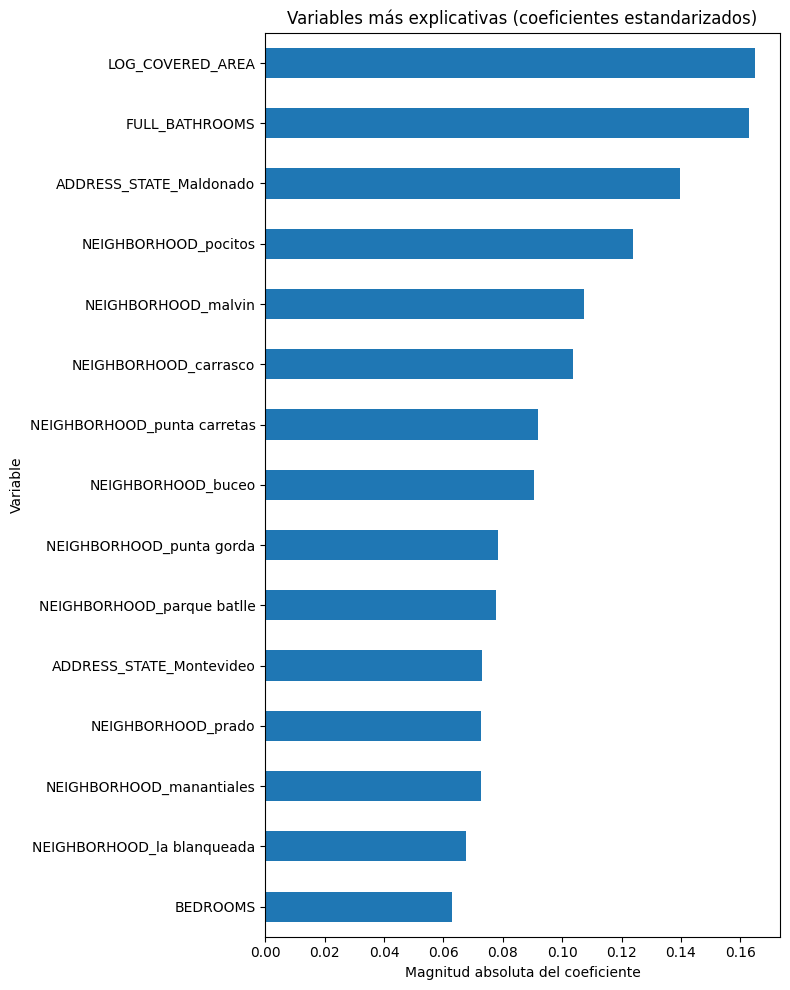

In [81]:
# === Importancia de variables (coeficientes estandarizados) ===
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
# 1) Estandarizar y reconstruir DataFrame conservando índice y columnas
X_tr_std = scaler.fit_transform(X_tr)
X_tr_std = pd.DataFrame(X_tr_std, index=X_tr.index, columns=X_tr.columns)

# 2) Reajustar OLS con variables estandarizadas
ols_std = sm.OLS(y_tr, sm.add_constant(X_tr_std)).fit()

# 3) Magnitud absoluta de coeficientes (sin la constante)
coef_abs = ols_std.params.drop('const').abs().sort_values(ascending=False)

# 4) Gráfico (top 15)
plt.figure(figsize=(8, 10))
coef_abs.head(15).iloc[::-1].plot(kind='barh')
plt.title('Variables más explicativas (coeficientes estandarizados)')
plt.xlabel('Magnitud absoluta del coeficiente')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


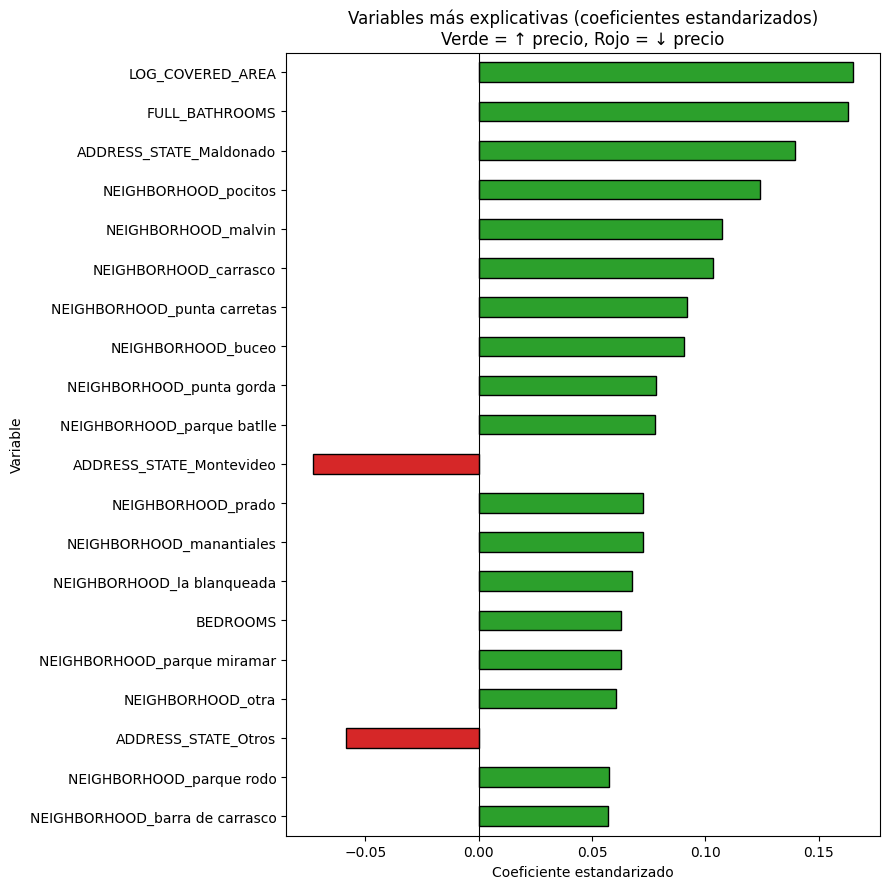

In [82]:
# coeficientes estandarizados del modelo
coef = ols_std.params.drop('const')  # conserva el signo

top_n = 20  # cantidad a mostrar
order = coef.abs().sort_values(ascending=False).index[:top_n]
coef_top = coef.loc[order]

# colores según signo
colors = ['tab:green' if v > 0 else 'tab:red' for v in coef_top]

plt.figure(figsize=(9, max(6, int(top_n * 0.45))))
# invertimos para que el más importante quede arriba
coef_top.iloc[::-1].plot(kind='barh', color=colors[::-1], edgecolor='black')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Variables más explicativas (coeficientes estandarizados)\nVerde = ↑ precio, Rojo = ↓ precio')
plt.xlabel('Coeficiente estandarizado')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# **7. Modelo Gradient Boosting**

Ya que de las 10 variables explicativas 6 son categóricas, procedemos a utilizar el modelo CatBoost.

## **7.1 Preparación de la Base**

In [83]:
X = df_sin_outliers_para_catboost[x_vars].copy()
y = df_sin_outliers_para_catboost[y_var].copy()


# Identificar categóricas
categoricas = ['NEIGHBORHOOD', 'LISTING_TYPE_ID', 'ADDRESS_STATE', 'CONDITION', 'WITH_VIRTUAL_TOUR', 'HAS_AIR_CONDITIONING']

In [84]:
# for i, c in enumerate(X.columns):
#     print(i, c, X[c].dtype, "CATEG?" , c in categoricas)

# # en esta versión de la base de datos CONDITION tiene datos faltantes los asignamos a la categoría not_specified
# # --- Limpieza específica de la variable CONDITION ---

# # 1) Unificar categorías equivalentes
# X['CONDITION'] = X['CONDITION'].replace({
#     'Estrenar': 'Nuevo',
#     'new': 'Nuevo',
#     'Impecable': 'Impecable',
#     'Buen estado': 'Buen estado',
#     'Reciclado': 'Reciclado',
#     'Para reciclar': 'Para reciclar',
#     'En construcción': 'En construcción',
#     'En pozo': 'En pozo',
#     'not_specified': 'No informado'   # opcional, podés mantenerlo separado si querés
# })

# # 2) Convertir NaN en una categoría válida (con sentido económico)
# X['CONDITION'] = X['CONDITION'].fillna('No informado')

# # 3) Asegurar el tipo correcto para CatBoost
# X['CONDITION'] = X['CONDITION'].astype('string')

# # --- Debug opcional para confirmar que quedó limpio ---
# print(X['CONDITION'].value_counts(dropna=False))
# print("Dtype:", X['CONDITION'].dtype)
# print("NaNs:", X['CONDITION'].isna().sum())


In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

## **7.2 Modelo CatBoost**

In [86]:

# Define model parameters
model_params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "l2_leaf_reg": 3,
    "loss_function": 'RMSE',
    "eval_metric": 'MAPE',
    "random_seed": 42,
    "verbose": False, # Set to False for cleaner output during CV
    "early_stopping_rounds": 100 # Early stopping for each fold
}
# Initialize KFold cross-validator
kf = KFold(n_splits=8, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_rmses = []
fold_maes = []
fold_r2s = []
fold_mape = []
print("Starting CatBoost Cross-Validation...")

# Ensure categorical columns are explicitly of 'category' dtype in X for robustness
for col in categoricas:
    if col in X.columns:
        X[col] = X[col].astype('category')

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    fold_model = CatBoostRegressor(**model_params)

    fold_model.fit(
        X_train_fold, y_train_fold,
        cat_features=categoricas,
        eval_set=(X_val_fold, y_val_fold),
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=False # Keep verbose off for cleaner CV output
    )

    y_pred_fold = fold_model.predict(X_val_fold)

    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)

    fold_rmses.append(rmse)
    fold_maes.append(mae)
    fold_mape.append(mape)
    fold_r2s.append(r2)

    print(f"Fold {fold+1} - RMSE: {rmse:,.2f}, MAE: {mae:,.2f}, R²: {r2:.3f}, MAPE: {mean_absolute_percentage_error(y_val_fold, y_pred_fold):.2%}")

print("\n--- Cross-Validation Results ---")
print(f"Average RMSE: {np.mean(fold_rmses):,.2f} \u00b1 {np.std(fold_rmses):,.2f}")
print(f"Average MAE: {np.mean(fold_maes):,.2f} \u00b1 {np.std(fold_maes):,.2f}")
print(f"Average R\u00b2: {np.mean(fold_r2s):.3f} \u00b1 {np.std(fold_r2s):.3f}")
print(f"Average MAPE: {np.mean(fold_mape):.2%}")

Starting CatBoost Cross-Validation...
Fold 1 - RMSE: 78,627.92, MAE: 49,047.67, R²: 0.653, MAPE: 34.59%
Fold 2 - RMSE: 73,774.59, MAE: 49,183.64, R²: 0.702, MAPE: 40.99%
Fold 3 - RMSE: 72,372.11, MAE: 48,771.51, R²: 0.697, MAPE: 30.88%
Fold 4 - RMSE: 67,871.67, MAE: 46,583.43, R²: 0.710, MAPE: 27.94%
Fold 5 - RMSE: 74,020.09, MAE: 49,587.11, R²: 0.684, MAPE: 31.66%
Fold 6 - RMSE: 73,365.28, MAE: 49,297.60, R²: 0.689, MAPE: 30.47%
Fold 7 - RMSE: 71,464.20, MAE: 48,136.16, R²: 0.684, MAPE: 33.89%
Fold 8 - RMSE: 88,084.09, MAE: 54,432.44, R²: 0.634, MAPE: 40.11%

--- Cross-Validation Results ---
Average RMSE: 74,947.49 ± 5,697.46
Average MAE: 49,379.94 ± 2,105.47
Average R²: 0.682 ± 0.024
Average MAPE: 33.82%


In [87]:
# def evaluar(y_true, y_pred, etiqueta='Set'):
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     r2 = r2_score(y_true, y_pred)
#     print(f"{etiqueta} -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R²: {r2:.3f} | MAPE: {mean_absolute_percentage_error(y_true, y_pred):.2%}")
#     return mae, rmse, r2

# print("\nResultados:")
# _ = evaluar(y_valid, fold_model.predict(X_valid), etiqueta='Validación')
# _ = evaluar(y_test,  fold_model.predict(X_test),  etiqueta='Test')


## **7.3 Importancia Relativa de las Variables**


Top 10 variables por importancia:
               Variable  Importancia
0          NEIGHBORHOOD        36.15
1          COVERED_AREA        18.01
7        FULL_BATHROOMS        17.16
5         ADDRESS_STATE         9.78
8              BEDROOMS         6.73
6             CONDITION         4.13
2       LISTING_TYPE_ID         3.85
9                GARAGE         3.18
4  HAS_AIR_CONDITIONING         0.92
3     WITH_VIRTUAL_TOUR         0.08


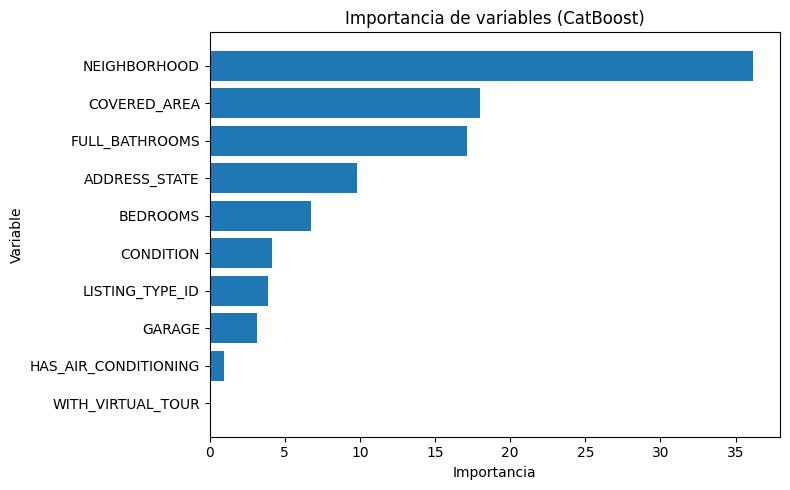

In [88]:
importancias = fold_model.get_feature_importance(prettified=True)
# Asegurar que se mapeen a los nombres de X (CatBoost ya devuelve 'Feature Id'/'Feature Name' en prettified)
imp_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': fold_model.get_feature_importance()
}).sort_values('Importancia', ascending=False)

print("\nTop 10 variables por importancia:")
print(imp_df.head(10))

# Gráfico
plt.figure(figsize=(8, 5))
plt.barh(imp_df['Variable'][:15][::-1], imp_df['Importancia'][:15][::-1])
plt.title('Importancia de variables (CatBoost)')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


## **7.4 Optimización con Optuna**

In [ ]:
# optuna usando solamente train y test.

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    """
    Define la función objetivo para la optimización de hiperparámetros de CatBoost
    utilizando Optuna, ¡ahora con K-Fold!
    """
    params = {
        "iterations": trial.suggest_int("iterations", 600, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 64),
        "loss_function": "RMSE",
        "eval_metric": "MAPE", # Métrica usada por CatBoost para early stopping
        "random_seed": 42,
        "verbose": False,
        "allow_writing_files": False
    }

    # Lista para almacenar el MAPE de cada pliegue
    mape_folds = []

    # Pruner para el K-Fold (opcional, pero mejora el rendimiento de Optuna)
    pruning_cb = CatBoostPruningCallback(trial, "MAPE")

    # 2. Iterar sobre cada pliegue (Fold)
    # kf.split genera los índices de Train y Validación (inner-train/inner-valid)
    for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
        # 3. Obtener los subconjuntos de datos para este pliegue
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        # Reiniciar el modelo para cada pliegue con los mismos parámetros
        model = CatBoostRegressor(**params)

        model.fit(
            X_train_fold, y_train_fold,
            cat_features=categoricas,
            eval_set=(X_valid_fold, y_valid_fold),
            use_best_model=True,
            early_stopping_rounds=200,
            callbacks=[pruning_cb] # El pruner de Optuna es por Trial, no por Fold
        )

        # 4. Calcular el MAPE de este pliegue (usamos el mejor score de CatBoost)
        best_scores = model.get_best_score()
        key = "validation" if "validation" in best_scores else ("eval" if "eval" in best_scores else None)

        if key is not None and "MAPE" in best_scores[key]:
            mape_folds.append(float(best_scores[key]["MAPE"]))
        else:
            # Fallback: calcular MAPE manualmente
            y_valid_pred = model.predict(X_valid_fold)
            mape_folds.append(float(mean_absolute_percentage_error(y_valid_fold, y_valid_pred)))



    # 5. OBJETIVO DE OPTUNA: Devolver el MAPE promedio de todos los pliegues
    avg_mape = np.mean(mape_folds)

    return avg_mape

# --- El resto del código de Optuna permanece igual ---
# ====== Crear y correr el estudio de Optuna ======
study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

print("Iniciando optimización de hiperparámetros con K-Fold...")
study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)


# Imprimir el mejor resultado (MAPE)
print("\n=== Mejor Resultado de Optuna ===")
print(f"Mejor MAPE Promedio (K-Fold): {study.best_value:.2%}")
print(f"Mejores Parámetros: {study.best_params}")


[I 2025-12-13 17:26:19,497] A new study created in memory with name: no-name-1a75f907-b39e-4d83-bc43-f6662093a410


Iniciando optimización de hiperparámetros con K-Fold...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 17:28:22,915] Trial 0 finished with value: 0.3200905560844422 and parameters: {'iterations': 1124, 'learning_rate': 0.13125830316209655, 'depth': 9, 'l2_leaf_reg': 3.968793330444372, 'bagging_temperature': 0.15601864044243652, 'subsample': 0.662397808134481, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.3200905560844422.
[I 2025-12-13 17:31:15,131] Trial 1 finished with value: 0.3222038195777087 and parameters: {'iterations': 1813, 'learning_rate': 0.05092911283433821, 'depth': 8, 'l2_leaf_reg': 1.0485387725194617, 'bagging_temperature': 0.9699098521619943, 'subsample': 0.9329770563201687, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.3200905560844422.
[I 2025-12-13 17:32:10,871] Trial 2 finished with value: 0.34438686306398847 and parameters: {'iterations': 854, 'learning_rate': 0.016432378919707624, 'depth': 6, 'l2_leaf_reg': 3.347776308515933, 'bagging_temperature': 0.43194501864211576, 'subsample': 0.7164916560792167, 'min_data_in_leaf': 40}. Best is 

## **7.5 Catboost con optuna para Maldonado**

In [ ]:
# ==========================
# 1. Filtrar Maldonado
# ==========================
df_filtrado = df_sin_outliers_para_catboost[
    df_sin_outliers_para_catboost["ADDRESS_STATE"] == "Maldonado"
].copy()

X = df_filtrado[x_vars].copy()
y = df_filtrado[y_var].copy()

# ==========================
# 3. Log-transformaciones
# ==========================

# Objetivo: log(PRICE)
y = np.log1p(y)

# Feature: log(COVERED_AREA) si existe
if "COVERED_AREA" in X.columns:
    X["COVERED_AREA"] = np.log1p(X["COVERED_AREA"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ==========================
# 7. K-Fold para Optuna
# ==========================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    """
    Optimizamos hiperparámetros de CatBoost entrenando en log(PRICE),
    pero minimizando el MAPE en PRECIO REAL.
    """

    params = {
        "iterations": trial.suggest_int("iterations", 600, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 64),
        "loss_function": "RMSE",   # RMSE en log(PRICE)
        "eval_metric": "RMSE",     # usamos RMSE para early stopping/pruning
        "random_seed": 42,
        "verbose": False,
        "allow_writing_files": False
    }

    mape_folds = []

    # Pruner basado en RMSE (en log-espacio)
    pruning_cb = CatBoostPruningCallback(trial, "RMSE")

    for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):

        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]  # log(PRICE)

        model = CatBoostRegressor(**params)

        model.fit(
            X_train_fold, y_train_fold,
            cat_features=categoricas,
            eval_set=(X_valid_fold, y_valid_fold),
            use_best_model=True,
            early_stopping_rounds=200,
            callbacks=[pruning_cb]
        )

        # Predicción en LOG-PRECIO
        y_valid_pred_log = model.predict(X_valid_fold)

        # Volver a PRECIO REAL
        y_valid_price = np.expm1(y_valid_fold)
        y_valid_pred_price = np.expm1(y_valid_pred_log)

        # MAPE en PRECIO REAL
        mape_fold = mean_absolute_percentage_error(y_valid_price, y_valid_pred_price)
        mape_folds.append(float(mape_fold))

    return np.mean(mape_folds)

# ==========================
# 8. Ejecutar Optuna
# ==========================

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

print("Iniciando optimización de hiperparámetros con K-Fold...")
study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)

print("\n=== Mejor Resultado de Optuna ===")
print(f"Mejor MAPE (K-Fold, PRECIO REAL): {study.best_value:.2%}")
print(f"Mejores Parámetros: {study.best_params}")


## **7.6 Catboost con optuna para Montevideo**

In [ ]:
# ==========================
# 1. Filtrar Maldonado
# ==========================
df_filtrado = df_sin_outliers_para_catboost[
    df_sin_outliers_para_catboost["ADDRESS_STATE"] == "Montevideo"
].copy()

# ==========================
# 2. Crear X e y (precio en nivel por ahora)
# ==========================
X = df_filtrado[x_vars].copy()
y = df_filtrado[y_var].copy()   # PRICE en nivel

# ==========================
# 3. Log-transformaciones
# ==========================

# Objetivo: log(PRICE)
y = np.log1p(y)   # log(1 + PRICE)

# Feature: log(COVERED_AREA) si existe
if "COVERED_AREA" in X.columns:
    X["COVERED_AREA"] = np.log1p(X["COVERED_AREA"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ==========================
# 7. K-Fold para Optuna
# ==========================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    """
    Optimizamos hiperparámetros de CatBoost entrenando en log(PRICE),
    pero minimizando el MAPE en PRECIO REAL.
    """

    params = {
        "iterations": trial.suggest_int("iterations", 600, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 64),
        "loss_function": "RMSE",   # RMSE en log(PRICE)
        "eval_metric": "RMSE",     # usamos RMSE para early stopping/pruning
        "random_seed": 42,
        "verbose": False,
        "allow_writing_files": False
    }

    mape_folds = []

    # Pruner basado en RMSE (en log-espacio)
    pruning_cb = CatBoostPruningCallback(trial, "RMSE")

    for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):

        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]  # log(PRICE)

        model = CatBoostRegressor(**params)

        model.fit(
            X_train_fold, y_train_fold,
            cat_features=categoricas,
            eval_set=(X_valid_fold, y_valid_fold),
            use_best_model=True,
            early_stopping_rounds=200,
            callbacks=[pruning_cb]
        )

        # Predicción en LOG-PRECIO
        y_valid_pred_log = model.predict(X_valid_fold)

        # Volver a PRECIO REAL
        y_valid_price = np.expm1(y_valid_fold)
        y_valid_pred_price = np.expm1(y_valid_pred_log)

        # MAPE en PRECIO REAL
        mape_fold = mean_absolute_percentage_error(y_valid_price, y_valid_pred_price)
        mape_folds.append(float(mape_fold))

    return np.mean(mape_folds)

# ==========================
# 8. Ejecutar Optuna
# ==========================

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

print("Iniciando optimización de hiperparámetros con K-Fold...")
study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)

print("\n=== Mejor Resultado de Optuna ===")
print(f"Mejor MAPE (K-Fold, PRECIO REAL): {study.best_value:.2%}")
print(f"Mejores Parámetros: {study.best_params}")


## **7.6 Catboost con optuna para Canelones**

In [ ]:
# ==========================
# 1. Filtrar Maldonado
# ==========================
df_filtrado = df_sin_outliers_para_catboost[
    df_sin_outliers_para_catboost["ADDRESS_STATE"] == "Canelones"
].copy()

# ==========================
# 2. Crear X e y (precio en nivel por ahora)
# ==========================
X = df_filtrado[x_vars].copy()
y = df_filtrado[y_var].copy()   # PRICE en nivel

# ==========================
# 3. Log-transformaciones
# ==========================

# Objetivo: log(PRICE)
y = np.log1p(y)   # log(1 + PRICE)

# Feature: log(COVERED_AREA) si existe
if "COVERED_AREA" in X.columns:
    X["COVERED_AREA"] = np.log1p(X["COVERED_AREA"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# ==========================
# 7. K-Fold para Optuna
# ==========================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    """
    Optimizamos hiperparámetros de CatBoost entrenando en log(PRICE),
    pero minimizando el MAPE en PRECIO REAL.
    """

    params = {
        "iterations": trial.suggest_int("iterations", 600, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 64),
        "loss_function": "RMSE",   # RMSE en log(PRICE)
        "eval_metric": "RMSE",     # usamos RMSE para early stopping/pruning
        "random_seed": 42,
        "verbose": False,
        "allow_writing_files": False
    }

    mape_folds = []

    # Pruner basado en RMSE (en log-espacio)
    pruning_cb = CatBoostPruningCallback(trial, "RMSE")

    for fold, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):

        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]  # log(PRICE)

        model = CatBoostRegressor(**params)

        model.fit(
            X_train_fold, y_train_fold,
            cat_features=categoricas,
            eval_set=(X_valid_fold, y_valid_fold),
            use_best_model=True,
            early_stopping_rounds=200,
            callbacks=[pruning_cb]
        )

        # Predicción en LOG-PRECIO
        y_valid_pred_log = model.predict(X_valid_fold)

        # Volver a PRECIO REAL
        y_valid_price = np.expm1(y_valid_fold)
        y_valid_pred_price = np.expm1(y_valid_pred_log)

        # MAPE en PRECIO REAL
        mape_fold = mean_absolute_percentage_error(y_valid_price, y_valid_pred_price)
        mape_folds.append(float(mape_fold))

    return np.mean(mape_folds)

# ==========================
# 8. Ejecutar Optuna
# ==========================

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=10)
)

print("Iniciando optimización de hiperparámetros con K-Fold...")
study.optimize(objective, n_trials=30, n_jobs=1, show_progress_bar=True)

print("\n=== Mejor Resultado de Optuna ===")
print(f"Mejor MAPE (K-Fold, PRECIO REAL): {study.best_value:.2%}")
print(f"Mejores Parámetros: {study.best_params}")


# **7. Conclusiones**


- El mejor modelo es CatBoost optimizado, que obtiene el menor error promedio.

- Con un precio promedio de USD 200.000, un MAPE de 25% implica un error típico de ± USD 50.000 por vivienda en Montevideo.

- Esto lo convierte en una herramienta confiable para estimar valores inmobiliarios.

Estos fueron los resultados finales:

| Modelo                               | MAPE    |
|--------------------------------------|---------|
| Regresión Lineal (RL)                | 39.9%   |
| CatBoost                             | 33.8%   |
| CatBoost + Optuna                    | 32.0%   |
| CatBoost + Optuna (Montevideo)       | 25.0%   |
| CatBoost + Optuna (Maldonado)        | 37.0%   |